# **YouTube Videos Analysis**

In this project we explore the YouTube trending videos dataset and uncover the key factors behind viral content. Through exploratory data analysis (EDA) and data visualization, we will analyze engagement patterns, trends, and content characteristics. we craft our own data-driven story and develop meaningful insights based on it.

In [ ]:
'''from google.colab import files
uploaded= files.upload()'''
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
import chardet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from warnings import warn
from ast import literal_eval
from scipy.stats import kruskal, chi2_contingency
from google.colab import files

Here we merge all the 10 csv files in the dataset. I added a col called country as well.

In [ ]:
input_dir = "/content/drive/MyDrive/DSC3/"
output_file = "merged_youtube_trending_complete.csv"

# List of encodings
ENCODINGS = ['utf-8', 'latin1', 'iso-8859-1', 'cp1252', 'MacRoman', 'utf-16']

dfs = []
failed_files = []

for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        country_name = file.replace('videos.csv', '').replace('.csv', '')
        file_path = os.path.join(input_dir, file)

        # Try multiple encoding strategies
        for encoding in ENCODINGS:
            try:
                df = pd.read_csv(file_path, encoding=encoding)
                df['country'] = country_name
                dfs.append(df)
                print(f"✓ Success: {file} with {encoding}")
                break
            except UnicodeDecodeError:
                continue
            except Exception as e:
                warn(f"Error with {encoding} on {file}: {str(e)}")
                continue
        else:
            # If all encodings failed, try with chardet
            try:
                with open(file_path, 'rb') as f:
                    rawdata = f.read(100000)
                    detected = chardet.detect(rawdata)

                df = pd.read_csv(file_path, encoding=detected['encoding'])
                df['country'] = country_name
                dfs.append(df)
                print(f" Success: {file} with detected {detected['encoding']}")
            except Exception as e:
                failed_files.append(file)
                print(f" Failed: {file} - {str(e)}")
                continue

if dfs:
    merged_df = pd.concat(dfs, ignore_index=True)
    merged_df.to_csv(output_file, index=False, encoding='utf-8')

    print(f"\n Successfully merged {len(dfs)} files into {output_file}")
    print(f"Total rows: {len(merged_df)}")

    if failed_files:
        print(f"\n Failed to process {len(failed_files)} files:")
        for f in failed_files:
            print(f"- {f}")
else:
    print(" No files were successfully processed")

#files.download(output_file)

✓ Success: CAvideos.csv with utf-8
✓ Success: DEvideos.csv with utf-8
✓ Success: FRvideos.csv with utf-8
✓ Success: GBvideos.csv with utf-8
✓ Success: INvideos.csv with utf-8
✓ Success: JPvideos.csv with latin1
✓ Success: KRvideos.csv with latin1
✓ Success: MXvideos.csv with latin1
✓ Success: RUvideos.csv with latin1
✓ Success: USvideos.csv with utf-8

 Successfully merged 10 files into merged_youtube_trending_complete.csv
Total rows: 375942


## Data Cleaning

In [ ]:
# Dataset Structure
print(merged_df.shape)
print()

# Define data types of all columns
merged_df.info()
print()

print("\nFirst 5 rows:")
print(merged_df.head())

merged_df

(375942, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375942 entries, 0 to 375941
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   video_id                375942 non-null  object
 1   trending_date           375942 non-null  object
 2   title                   375942 non-null  object
 3   channel_title           375942 non-null  object
 4   category_id             375942 non-null  int64 
 5   publish_time            375942 non-null  object
 6   tags                    375942 non-null  object
 7   views                   375942 non-null  int64 
 8   likes                   375942 non-null  int64 
 9   dislikes                375942 non-null  int64 
 10  comment_count           375942 non-null  int64 
 11  thumbnail_link          375942 non-null  object
 12  comments_disabled       375942 non-null  bool  
 13  ratings_disabled        375942 non-null  bool  
 14  video_error_or_removed

video_id trending_date  \
0       n1WpP7iowLc      17.14.11   
1       0dBIkQ4Mz1M      17.14.11   
2       5qpjK5DgCt4      17.14.11   
3       d380meD0W0M      17.14.11   
4       2Vv-BfVoq4g      17.14.11   
...             ...           ...   
375937  BZt0qjTWNhw      18.14.06   
375938  1h7KV2sjUWY      18.14.06   
375939  D6Oy4LfoqsU      18.14.06   
375940  oV0zkMe1K8s      18.14.06   
375941  ooyjaVdt-jA      18.14.06   

                                                    title  \
0              Eminem - Walk On Water (Audio) ft. Beyoncé   
1                           PLUSH - Bad Unboxing Fan Mail   
2       Racist Superman | Rudy Mancuso, King Bach & Le...   
3                                I Dare You: GOING BALD!?   
4             Ed Sheeran - Perfect (Official Music Video)   
...                                                   ...   
375937                       The Cat Who Caught the Laser   
375938                         True Facts : Ant Mutualism   
375939  I GAVE SAFIYA NYGAARD A PERFECT HAIR MAKEOVER ...   
375940                How Black Panther Should Have Ended   
375941  Official Call of Duty®: Black Ops 4 — Multipla...   

                   channel_title  category_id              publish_time  \
0                     EminemVEVO           10  2017-11-10T17:00:03.000Z   
1                      iDubbbzTV           23  2017-11-13T17:00:00.000Z   
2                   Rudy Mancuso           23  2017-11-12T19:05:24.000Z   
3                       nigahiga           24  2017-11-12T18:01:41.000Z   
4                     Ed Sheeran           10  2017-11-09T11:04:14.000Z   
...                          ...          ...                       ...   
375937             AaronsAnimals           15  2018-05-18T13:00:04.000Z   
375938                  zefrank1           22  2018-05-18T01:00:06.000Z   
375939                Brad Mondo           24  2018-05-18T17:34:22.000Z   
375940  How It Should Have Ended            1  2018-05-17T17:00:04.000Z   
375941              Call of Duty           20  2018-05-17T17:09:38.000Z   

                                                     tags     views    likes  \
0       Eminem|"Walk"|"On"|"Water"|"Aftermath/Shady/In...  17158579   787425   
1       plush|"bad unboxing"|"unboxing"|"fan mail"|"id...   1014651   127794   
2       racist superman|"rudy"|"mancuso"|"king"|"bach"...   3191434   146035   
3       ryan|"higa"|"higatv"|"nigahiga"|"i dare you"|"...   2095828   132239   
4       edsheeran|"ed sheeran"|"acoustic"|"live"|"cove...  33523622  1634130   
...                                                   ...       ...      ...   
375937  aarons animals|"aarons"|"animals"|"cat"|"cats"...   1685609    38160   
375938                                             [none]   1064798    60008   
375939  I gave safiya nygaard a perfect hair makeover ...   1066451    48068   
375940  Black Panther|"HISHE"|"Marvel"|"Infinity War"|...   5660813   192957   
375941      call of duty|"cod"|"activision"|"Black Ops 4"  10306119   357079   

        dislikes  comment_count  \
0          43420         125882   
1           1688          13030   
2           5339           8181   
3           1989          17518   
4          21082          85067   
...          ...            ...   
375937      1385           2657   
375938       382           3936   
375939      1032           3992   
375940      2846          13088   
375941    212976         144795   

                                        thumbnail_link  comments_disabled  \
0       https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg              False   
1       https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg              False   
2       https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg              False   
3       https://i.ytimg.com/vi/d380meD0W0M/default.jpg              False   
4       https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg              False   
...                                                ...                ...   
375937  htt

In [ ]:
## 1. Handle Missing Values
print("Missing values before cleaning:")
print(merged_df.isnull().sum())
print()

# Fill missing
df['description'].fillna("no description", inplace=True)

print("\nMissing values after cleaning:")
print(df.isnull().sum())

Missing values before cleaning:
video_id                      0
trending_date                 0
title                         0
channel_title                 0
category_id                   0
publish_time                  0
tags                          0
views                         0
likes                         0
dislikes                      0
comment_count                 0
thumbnail_link                0
comments_disabled             0
ratings_disabled              0
video_error_or_removed        0
description               19478
country                       0
dtype: int64


Missing values after cleaning:
video_id                  0
trending_date             0
title                     0
channel_title             0
category_id               0
publish_time              0
tags                      0
views                     0
likes                     0
dislikes                  0
comment_count             0
thumbnail_link            0
comments_disabled         0
ratings_disabl

<ipython-input-5-e7b6faddaab6>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['description'].fillna("no description", inplace=True)


In [ ]:
## 2. Convert Data Types
# Convert dates to datetime
merged_df['trending_date'] = pd.to_datetime(merged_df['trending_date'], format='%y.%d.%m')
merged_df['publish_time'] = pd.to_datetime(merged_df['publish_time'])

# Convert boolean columns properly
bool_cols = ['comments_disabled', 'ratings_disabled', 'video_error_or_removed']
for col in bool_cols:
    merged_df[col] = merged_df[col].astype(bool)

In [ ]:
## 3. Clean Text Data
def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^\w\s.,!?]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

merged_df['title'] = merged_df['title'].apply(clean_text)
merged_df['description'] = merged_df['description'].apply(clean_text)
merged_df['channel_title'] = merged_df['channel_title'].apply(clean_text)

'''# Clean tags (often stored as lists)
def clean_tags(tags):
    try:
        if tags.startswith('["') and tags.endswith('"]'):
            tags_list = literal_eval(tags)
            return '|'.join([clean_text(tag) for tag in tags_list])
        return clean_text(tags)
    except:
        return ""

merged_df['tags'] = merged_df['tags'].apply(clean_tags)'''

'# Clean tags (often stored as lists)\ndef clean_tags(tags):\n    try:\n        if tags.startswith(\'["\') and tags.endswith(\'"]\'):\n            tags_list = literal_eval(tags)\n            return \'|\'.join([clean_text(tag) for tag in tags_list])\n        return clean_text(tags)\n    except:\n        return ""\n\nmerged_df[\'tags\'] = merged_df[\'tags\'].apply(clean_tags)'

In [ ]:
## 4. Handle Outliers
# Cap extreme values at 99th percentile
num_cols = ['views', 'likes', 'dislikes', 'comment_count']
for col in num_cols:
    upper_limit = merged_df[col].quantile(0.99)
    merged_df[col] = np.where(merged_df[col] > upper_limit, upper_limit, merged_df[col])

In [ ]:
#5. Count total duplicate rows (all columns identical)
total_duplicates = merged_df.duplicated().sum()
print(f"Total exact duplicate rows: {total_duplicates}")

# Show sample duplicate rows
duplicate_rows = merged_df[merged_df.duplicated(keep=False)]  # keep=False marks all duplicates
print("\nSample duplicate rows:")
print(duplicate_rows.sort_values(by=list(merged_df.columns)).head())

Total exact duplicate rows: 12599

Sample duplicate rows:
       video_id trending_date                                          title  \
220732   #NAME?    2017-11-22                                        vlog049   
220856   #NAME?    2017-11-22                                        vlog049   
220711   #NAME?    2017-11-22  ê¹ììì ëìê³µì 17.11.20 ì¼ìì, ììêµ, ìì ì, ì ì í   
220835   #NAME?    2017-11-22  ê¹ììì ëìê³µì 17.11.20 ì¼ìì, ììêµ, ìì ì, ì ì í   
220689   #NAME?    2017-11-22                            ë¹ì¹ ìì ì feat.ììì¼   

       channel_title  category_id              publish_time  \
220732   im hae yeon           22 2017-11-18 12:06:33+00:00   
220856   im hae yeon           22 2017-11-18 12:06:33+00:00   
220711    moonsrever           25 2017-11-20 00:12:32+00:00   
220835    moonsrever           25 2017-11-20 00:12:32+00:00   
220689        ì ìëìë           10 2017-11-20 12:41:50+00:00   

                                                     tags     views   likes  \
220

In [ ]:
# Before removal
print(f"Original shape: {merged_df.shape}")

# Remove all rows where every column value is identical
merged_df.drop_duplicates(inplace=True)

# After removal
print(f"Shape after removing exact duplicates: {merged_df.shape}")

Original shape: (375942, 17)
Shape after removing exact duplicates: (363343, 17)


In [ ]:
print(f"\nFinal dataset shape: {merged_df.shape}")


Final dataset shape: (363343, 17)


## EDA

In [ ]:
# basic statistics
print(merged_df.describe())
print()

# statistics of the object datatype data
print(merged_df.describe(include='object'))
print()

# Define data types of all columns
merged_df.info()
print()

# print the unique values or the categories of categorical fwatures:
for column in merged_df.columns:
    if merged_df[column].dtype == 'object':
        print(column)
        print(merged_df[column].unique())
        print()

                       trending_date    category_id         views  \
count                         363343  363343.000000  3.633430e+05   
mean   2018-02-27 07:30:47.870469632      20.219938  1.024412e+06   
min              2017-11-14 00:00:00       1.000000  1.170000e+02   
25%              2018-01-04 00:00:00      17.000000  4.628750e+04   
50%              2018-02-27 00:00:00      23.000000  1.762380e+05   
75%              2018-04-23 00:00:00      24.000000  6.497480e+05   
max              2018-06-14 00:00:00      44.000000  2.051770e+07   
std                              NaN       7.142447  2.849075e+06   

               likes       dislikes  comment_count  
count  363343.000000  363343.000000  363343.000000  
mean    31192.477646    1408.550262    3236.374237  
min         0.000000       0.000000       0.000000  
25%       673.000000      41.000000     109.000000  
50%      3516.000000     179.000000     518.000000  
75%     17851.500000     753.000000    2046.000000  
max    

In [ ]:
# Set visualization style
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)


Views, Likes, Dislikes, and Comments Distribution

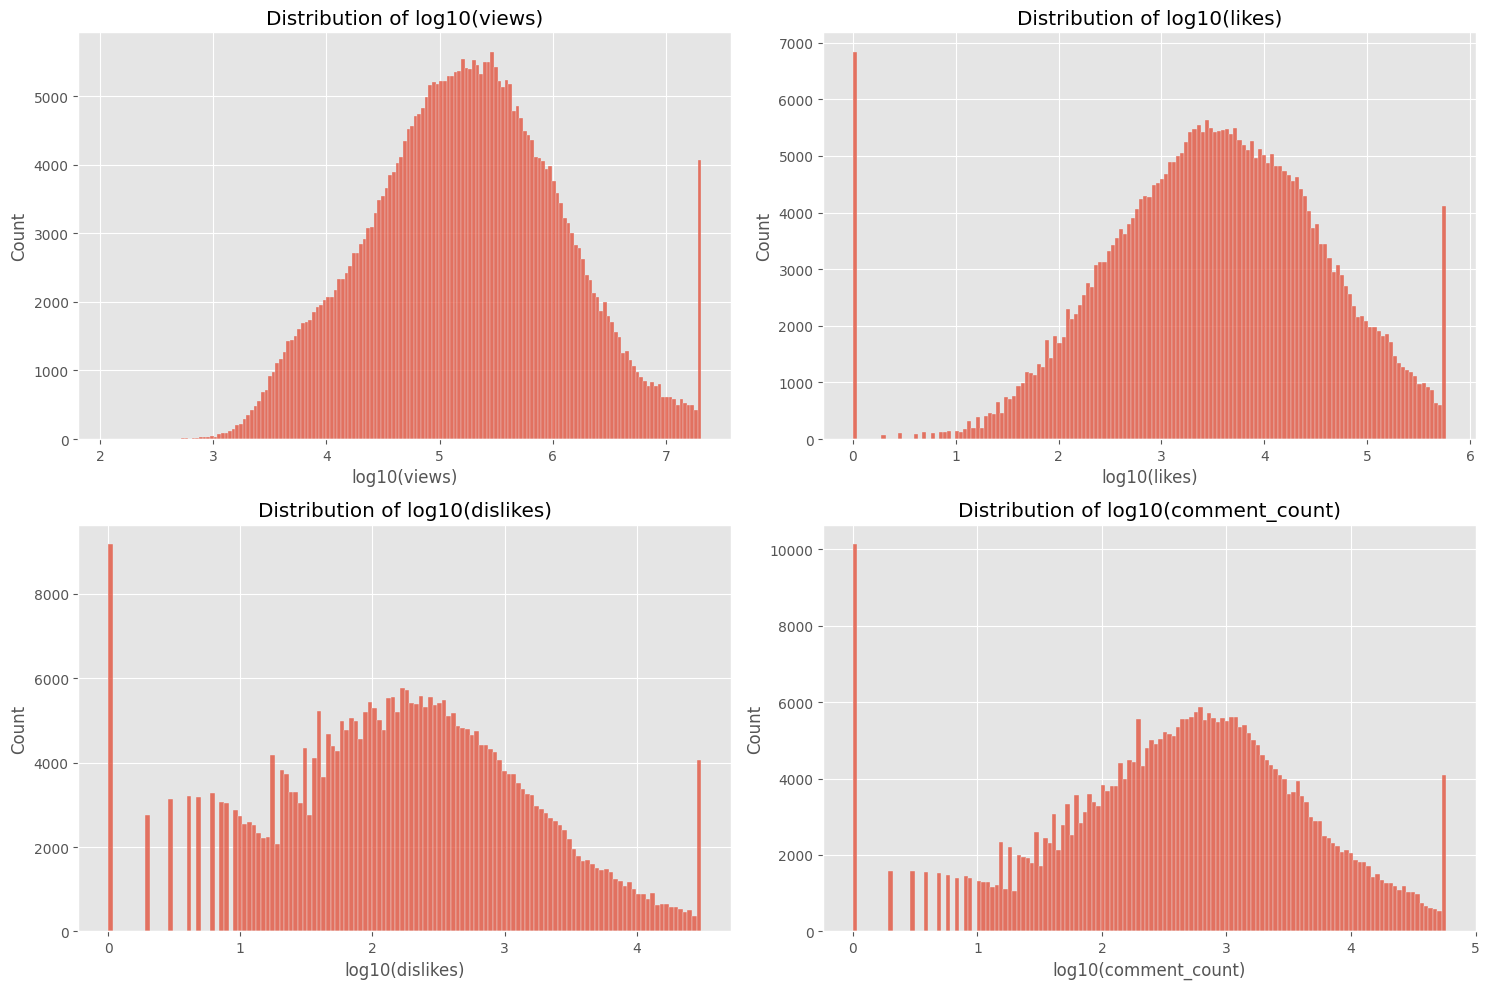

In [ ]:

# Plot distribution of engagement metrics
engagement_metrics = ['views', 'likes', 'dislikes', 'comment_count']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, metric in enumerate(engagement_metrics):
    sns.histplot(np.log10(merged_df[metric] + 1), ax=axes[i])
    axes[i].set_title(f'Distribution of log10({metric})')
    axes[i].set_xlabel(f'log10({metric})')

plt.tight_layout()
plt.show()

Correlation Between Engagement Metrics

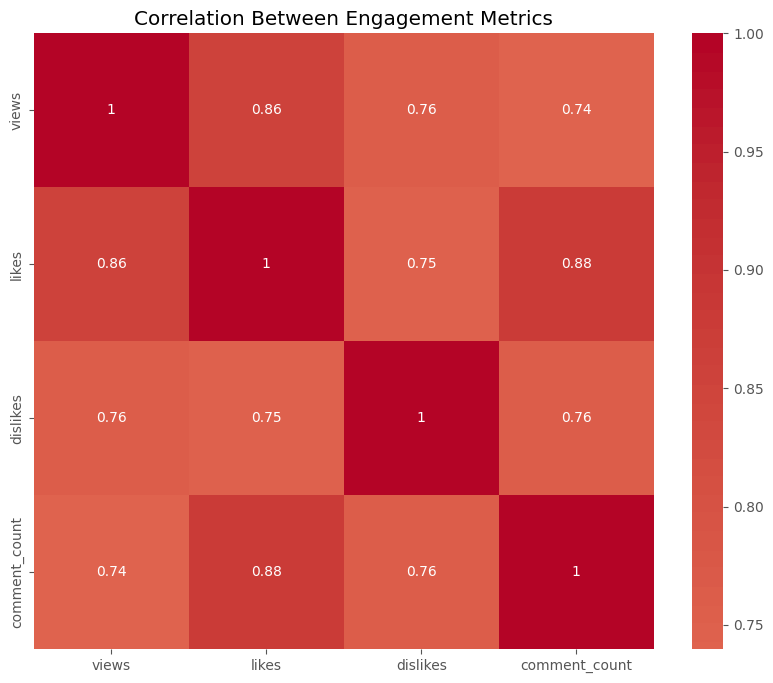

In [ ]:
# Calculate correlation matrix
corr_matrix = merged_df[['views', 'likes', 'dislikes', 'comment_count']].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Engagement Metrics')
plt.show()

Videos Trending Over Time

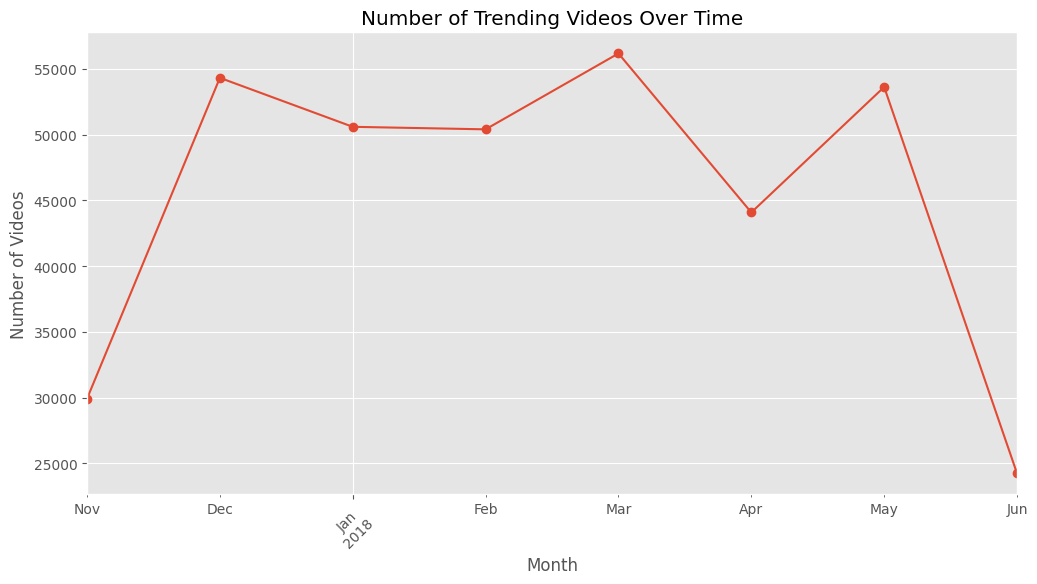

In [ ]:
# Extract month and year from trending date
merged_df['trending_month'] = merged_df['trending_date'].dt.to_period('M')

# Count videos per month
trending_counts = merged_df.groupby('trending_month').size()

# Plot trend
trending_counts.plot(kind='line', marker='o')
plt.title('Number of Trending Videos Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Videos')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Most Common Categories

In [ ]:
# upload json filess
from google.colab import files
uploaded = files.upload()

Saving CA_category_id.json to CA_category_id.json
Saving DE_category_id.json to DE_category_id.json
Saving FR_category_id.json to FR_category_id.json
Saving GB_category_id.json to GB_category_id.json
Saving IN_category_id.json to IN_category_id.json
Saving JP_category_id.json to JP_category_id.json
Saving KR_category_id.json to KR_category_id.json
Saving MX_category_id.json to MX_category_id.json
Saving RU_category_id.json to RU_category_id.json
Saving US_category_id.json to US_category_id.json


Category Map: {1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music', 15: 'Pets & Animals', 17: 'Sports', 18: 'Short Movies', 19: 'Travel & Events', 20: 'Gaming', 21: 'Videoblogging', 22: 'People & Blogs', 23: 'Comedy', 24: 'Entertainment', 25: 'News & Politics', 26: 'Howto & Style', 27: 'Education', 28: 'Science & Technology', 30: 'Movies', 31: 'Anime/Animation', 32: 'Action/Adventure', 33: 'Classics', 34: 'Comedy', 35: 'Documentary', 36: 'Drama', 37: 'Family', 38: 'Foreign', 39: 'Horror', 40: 'Sci-Fi/Fantasy', 41: 'Thriller', 42: 'Shorts', 43: 'Shows', 44: 'Trailers', 29: 'Nonprofits & Activism'}
Category Names for IDs: ['Film & Animation', 'Autos & Vehicles', 'Music']


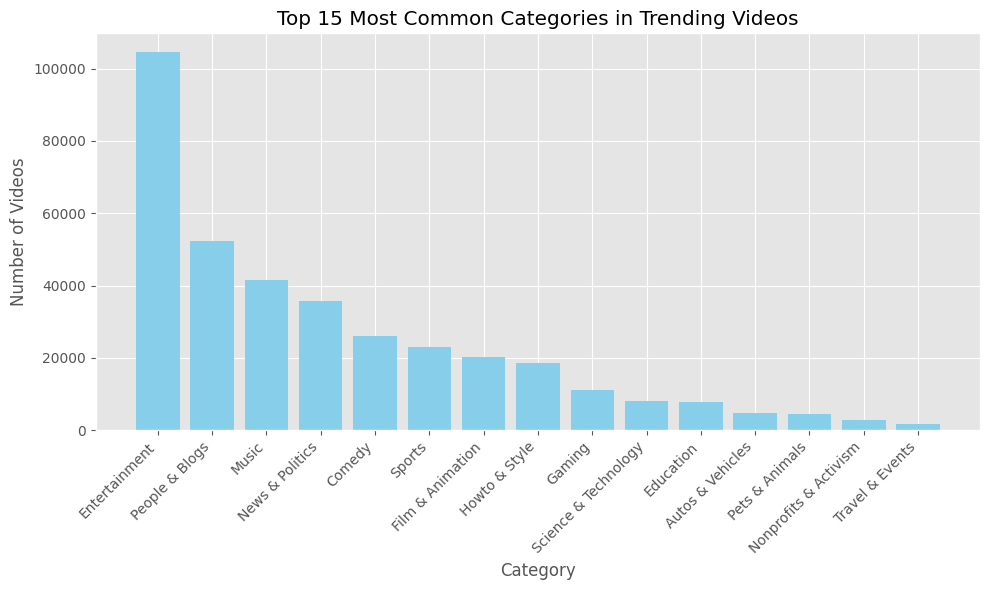

In [ ]:
import json
# map category_ids to category names using json files
merged_data = []

for filename in uploaded.keys():
    with open(filename, 'r') as f:
        data = json.load(f)
        if 'items' in data:
            for item in data['items']:
                # Ensure item has required structure
                if 'id' in item and 'snippet' in item and 'title' in item['snippet']:
                    merged_data.append({
                        'id': int(item['id']),
                        'name': item['snippet']['title']
                    })

# Remove duplicates by 'id'
seen_ids = set()
unique_data = []
for item in merged_data:
    if item['id'] not in seen_ids:
        unique_data.append(item)
        seen_ids.add(item['id'])

#  Create category map
category_map = {cat['id']: cat['name'] for cat in unique_data}

# Example usage
category_ids = [1, 2, 10]
category_names = [category_map.get(cid, "Unknown") for cid in category_ids]

print("Category Map:", category_map)
print("Category Names for IDs:", category_names)

# Save the merged category list
with open("merged_categories.json", "w") as f:
    json.dump(unique_data, f, indent=2)

#Get top 15 most common category IDs
category_counts = merged_df['category_id'].value_counts().head(15)

# Map IDs to names using category_map (from earlier)
category_names = [category_map.get(cat_id, "Unknown") for cat_id in category_counts.index]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(category_names, category_counts.values, color='skyblue')

plt.title('Top 15 Most Common Categories in Trending Videos')
plt.xlabel('Category')
plt.ylabel('Number of Videos')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Top Channels by Appearance Count

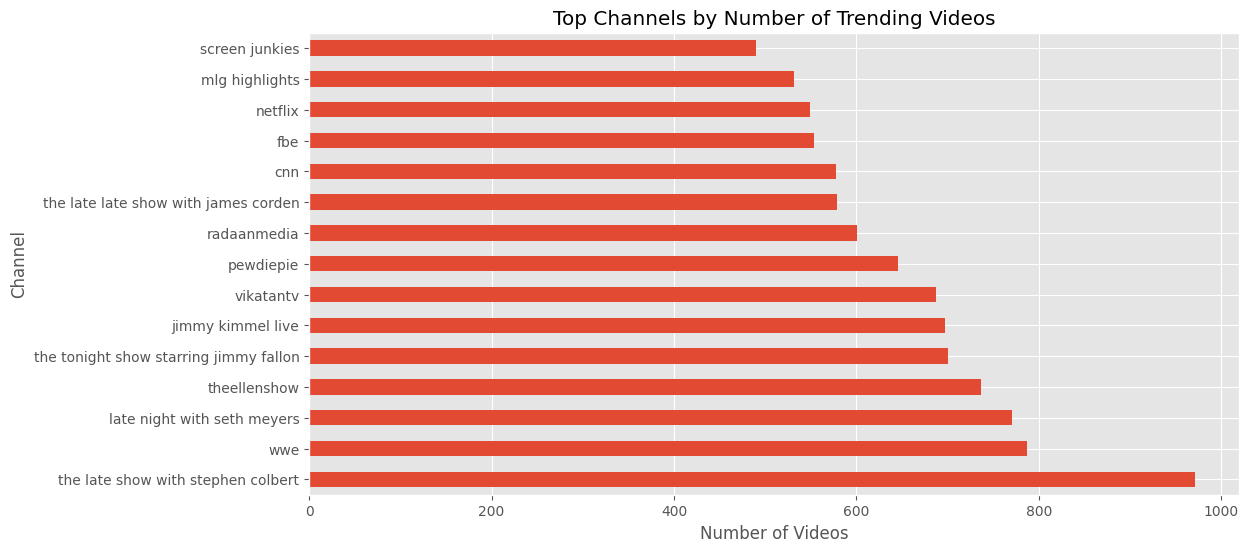

In [ ]:
top_channels = merged_df['channel_title'].value_counts().head(15)

top_channels.plot(kind='barh')
plt.title('Top Channels by Number of Trending Videos')
plt.xlabel('Number of Videos')
plt.ylabel('Channel')
plt.show()

Trending Videos by Country

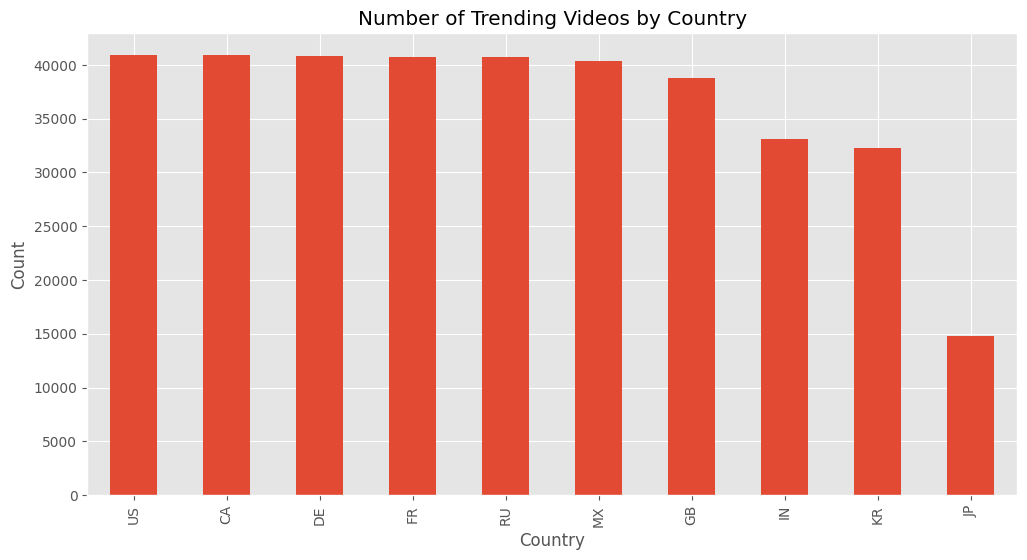

In [ ]:
country_counts = merged_df['country'].value_counts()

country_counts.plot(kind='bar')
plt.title('Number of Trending Videos by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

Average Engagement Metrics by Country

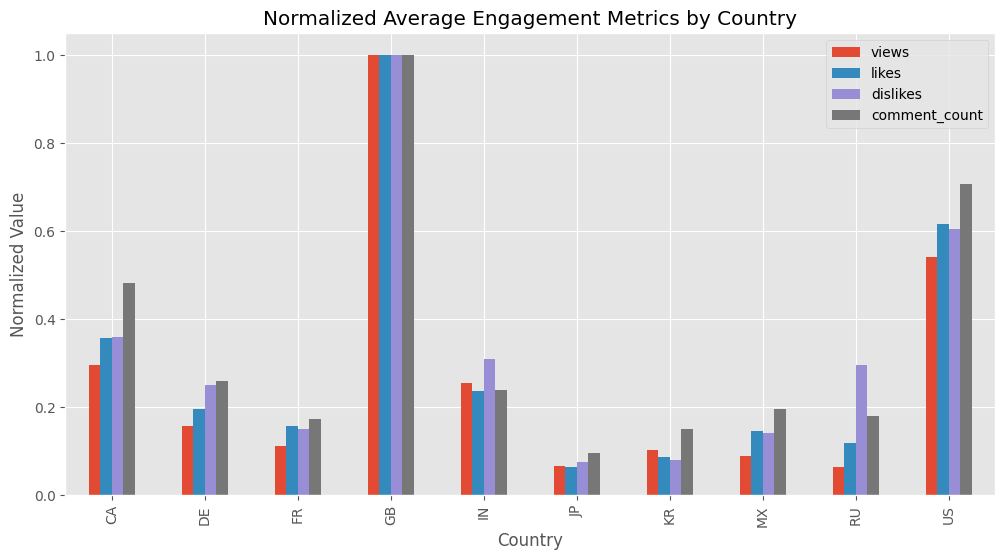

In [ ]:
country_engagement = merged_df.groupby('country')[['views', 'likes', 'dislikes', 'comment_count']].mean()

# Normalize for better comparison
country_engagement_norm = country_engagement.apply(lambda x: x/x.max(), axis=0)

country_engagement_norm.plot(kind='bar', figsize=(12, 6))
plt.title('Normalized Average Engagement Metrics by Country')
plt.xlabel('Country')
plt.ylabel('Normalized Value')
plt.legend(loc='upper right')
plt.show()

Most Common Tags in Trending Videos

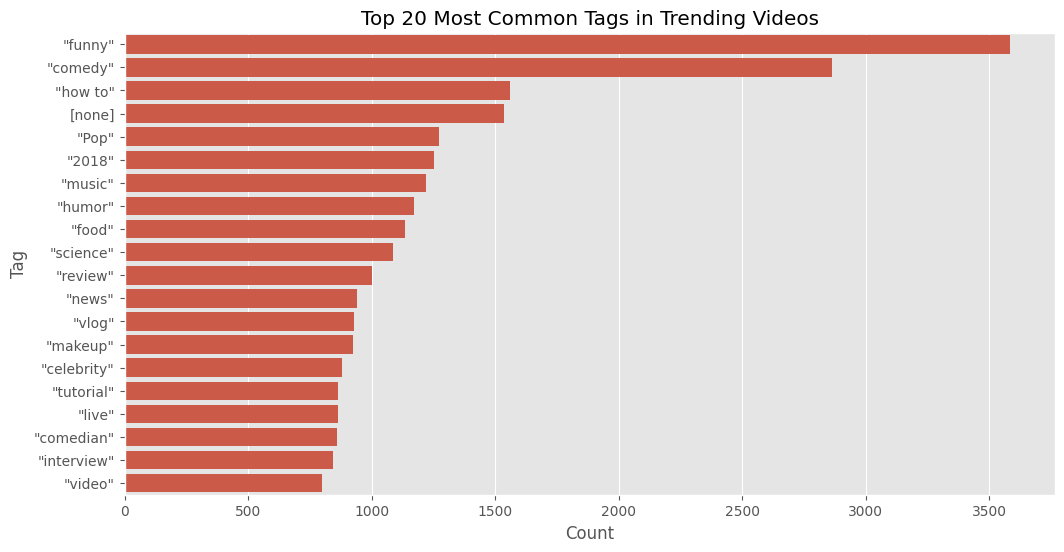

In [ ]:
from collections import Counter

# Split tags and count occurrences
all_tags = '|'.join(df['tags'].dropna()).split('|')
tag_counts = Counter(all_tags)

# Get top 20 tags
top_tags = pd.DataFrame(tag_counts.most_common(20), columns=['tag', 'count'])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_tags, x='count', y='tag')
plt.title('Top 20 Most Common Tags in Trending Videos')
plt.xlabel('Count')
plt.ylabel('Tag')
plt.show()

## Storyline

What Factors Drive a Video to Trend on YouTube?

To understand YouTube trends I will analyze how views, likes, dislikes, comments, category, and engagement metrics influence a video's popularity.

### 1. Which video categories are most frequently trending?

<ipython-input-23-0218b85340db>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_names, y=category_counts.values, palette='viridis')


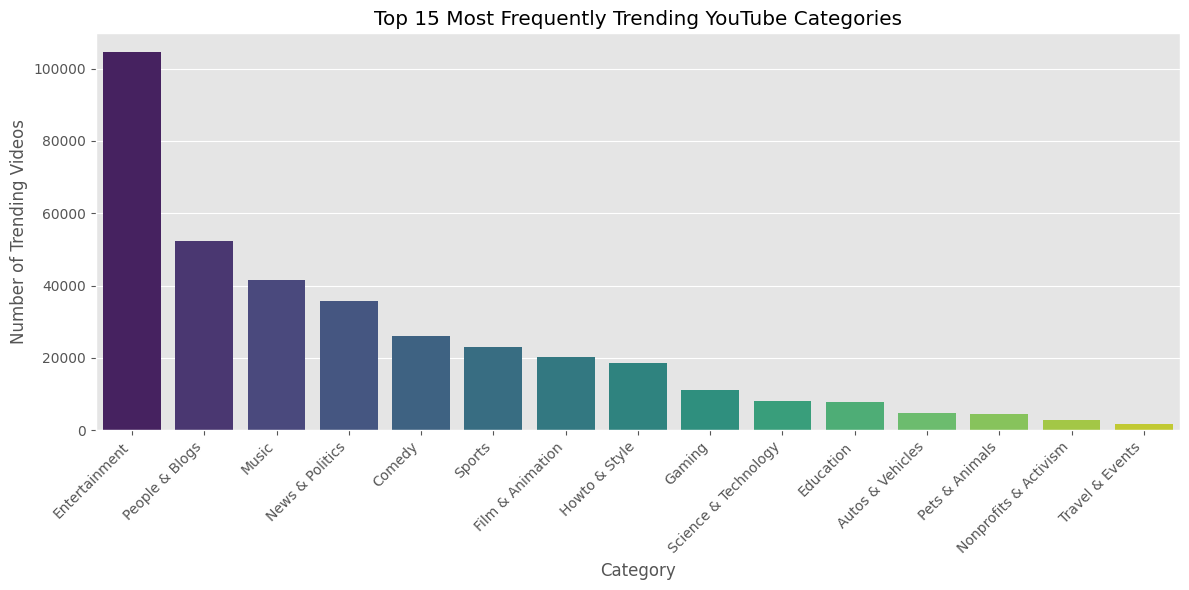

In [ ]:
# Convert date columns to datetime
merged_df['trending_date'] = pd.to_datetime(merged_df['trending_date'], format='%y.%d.%m')
merged_df['publish_time'] = pd.to_datetime(merged_df['publish_time'])

# Feature engineering
merged_df['publish_hour'] = merged_df['publish_time'].dt.hour
merged_df['publish_day'] = merged_df['publish_time'].dt.day_name()
merged_df['title_length'] = merged_df['title'].apply(len)
merged_df['tag_count'] = merged_df['tags'].apply(lambda x: len(x.split('|')) if x != '[none]' else 0)

# Get top 15 most common category IDs
category_counts = merged_df['category_id'].value_counts().head(15)

# Map category IDs to names
category_names = [category_map.get(cat_id, "Unknown") for cat_id in category_counts.index]

#Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=category_names, y=category_counts.values, palette='viridis')

plt.title('Top 15 Most Frequently Trending YouTube Categories')
plt.xlabel('Category')
plt.ylabel('Number of Trending Videos')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 2. Does the time of publishing (publish_time) affect trending chances?

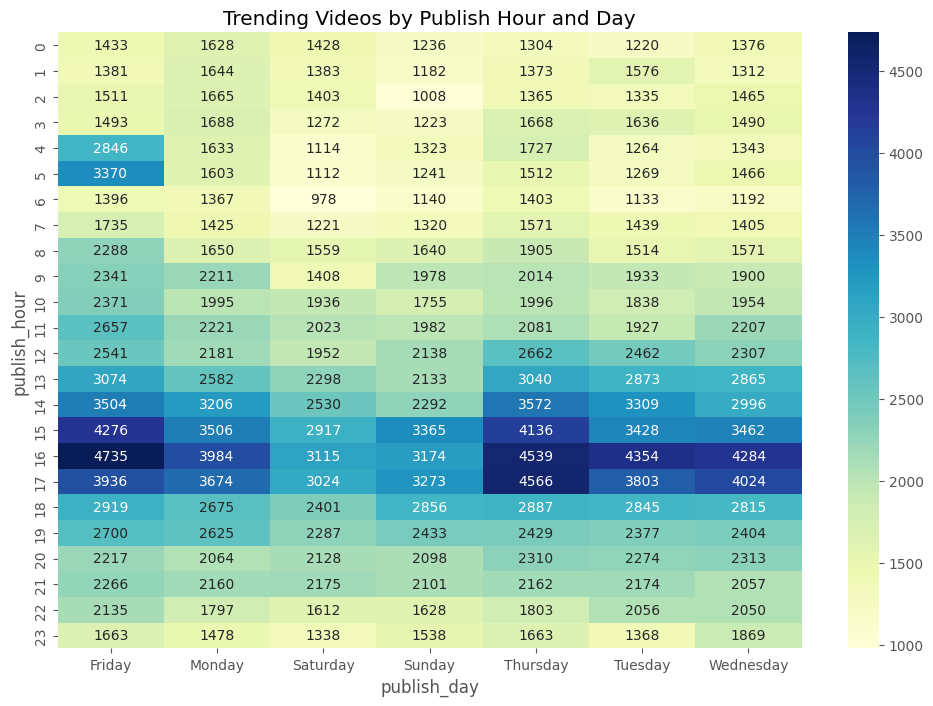

In [ ]:
# Heatmap: Trending frequency by hour and day
heatmap_data = merged_df.groupby(['publish_hour', 'publish_day']).size().unstack()
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt='d')
plt.title("Trending Videos by Publish Hour and Day")
plt.show()

Insight: Videos published in peak hours (evenings/some special days of week) may trend more. Since at these times most of the people have free time to check videos on youtube so it can become trend instancely.

### 3. How do likes, dislikes, and comments correlate with views?

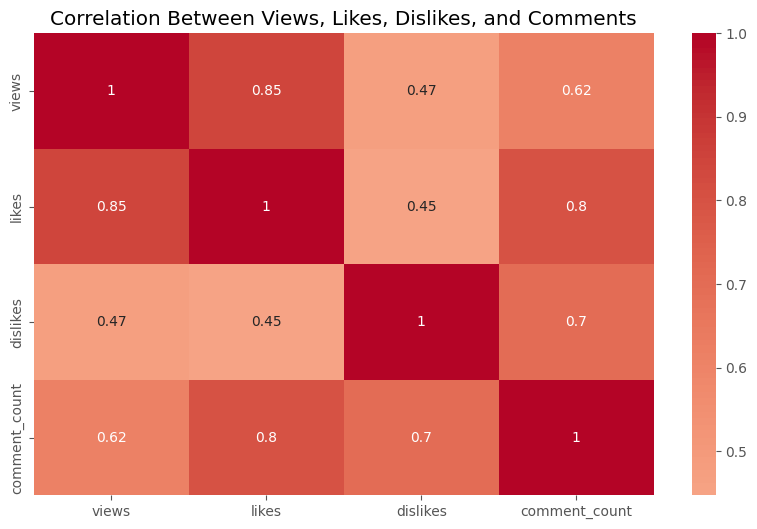

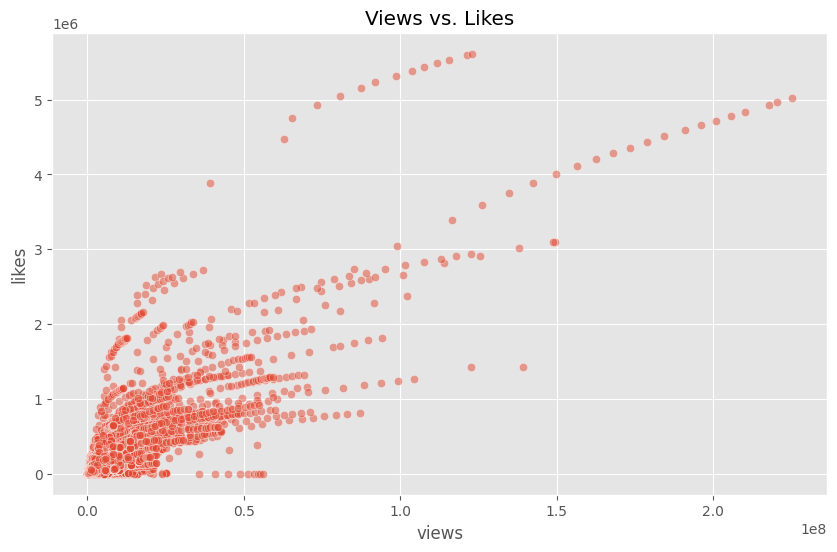

In [ ]:
# Select numeric columns
numeric_cols = ['views', 'likes', 'dislikes', 'comment_count']
corr_matrix = df[numeric_cols].corr()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Between Views, Likes, Dislikes, and Comments")
plt.show()

# Scatter plot: Views vs. Likes
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='views', y='likes', alpha=0.5)
plt.title("Views vs. Likes")
plt.show()

As we can see there is strong positive correllation between views and likes which means that the more likes a video gets the more likle it is , to become trend.

### 4. Do videos with disabled comments or ratings trend differently?


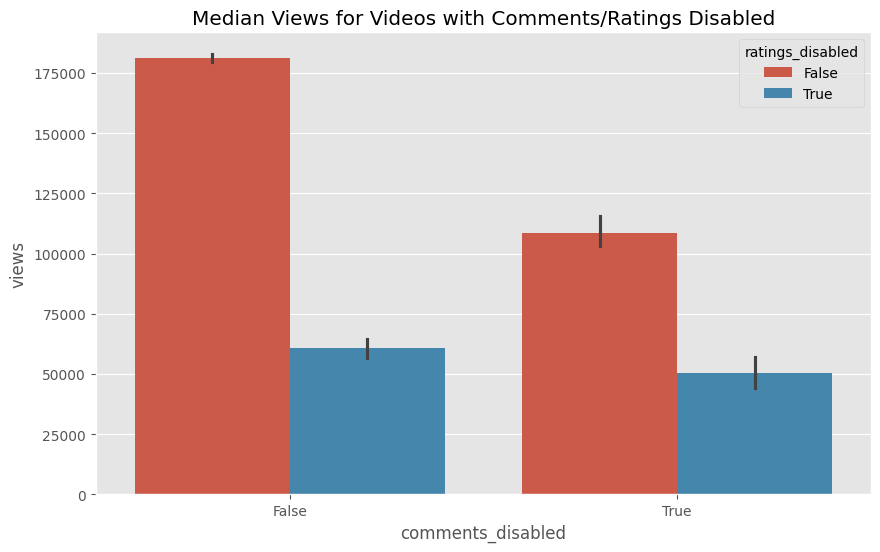

In [ ]:
# Group by disabled features and compare median views
disabled_comparison = merged_df.groupby(['comments_disabled', 'ratings_disabled'])['views'].median().unstack()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=merged_df, x='comments_disabled', y='views', hue='ratings_disabled', estimator=np.median)
plt.title("Median Views for Videos with Comments/Ratings Disabled")
plt.show()

Insight: Videos with enabled engagement features may trend more.
So we understand the more the viewers engage with the videos the more likely it is that the video become trend.


### 5. Which countries have the highest trending video counts?

In [ ]:
import plotly.express as px

# Count by country
country_counts = merged_df['country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

# Bar chart (Plotly)
fig = px.bar(
    country_counts,
    x='country',
    y='count',
    color='count',
    title="Trending Videos by Country",
    labels={'count': 'Number of Trending Videos', 'country': 'Country'},
    text='count'  # Display counts on bars
)

# Customize layout
fig.update_layout(
    xaxis_title="Country",
    yaxis_title="Number of Trending Videos",
    xaxis={'categoryorder': 'total descending'},  # Sort bars by count
    hovermode="x",
    template="plotly_white"
)

# Rotate x-axis labels if needed
fig.update_xaxes(tickangle=45)

fig.show()

Insight: as we can see the most trending videos are  mostly for US and Canada which we can conclude that the probability that videos with english language become trend is higher. Then we have the europen countries and the least number of trending vodeos is for asian countries. For a better and a more detailed conclusion we can add the datasets of more countries.

### 6. Is there a relationship between title length and trending success?

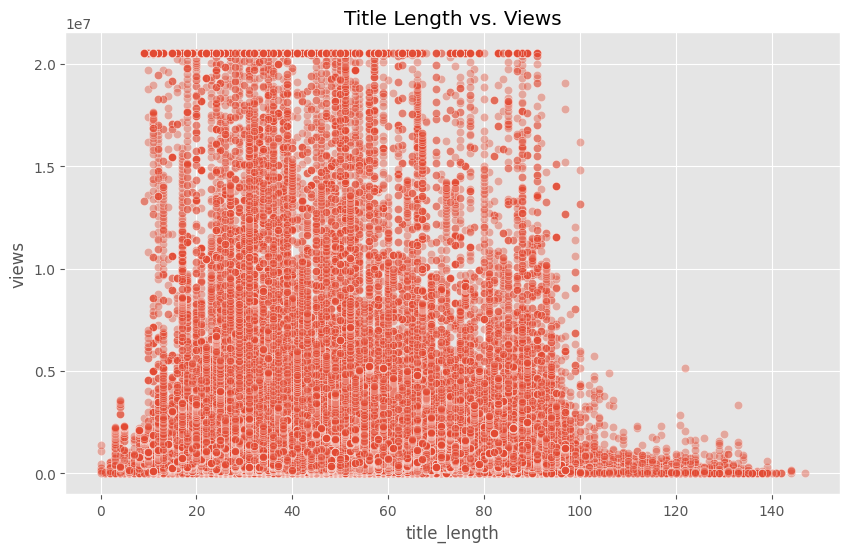

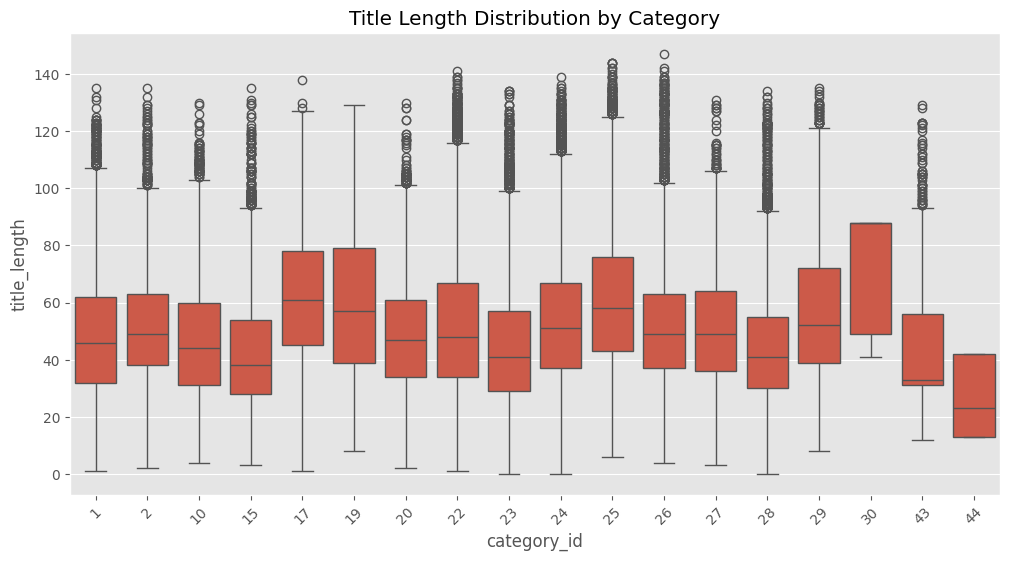

In [ ]:
# Scatter plot: Title length vs. views
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='title_length', y='views', alpha=0.4)
plt.title("Title Length vs. Views")
plt.show()

# Box plot: Title length by category
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df, x='category_id', y='title_length')
plt.xticks(rotation=45)
plt.title("Title Length Distribution by Category")
plt.show()

Insight: Optimal title length (neither too short nor too long) may perform better.

### 7.Does the Time-to-Trend (Gap Between Publish and Trending) Affect Video Performance?

<ipython-input-29-6891e323ab3a>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-29-6891e323ab3a>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



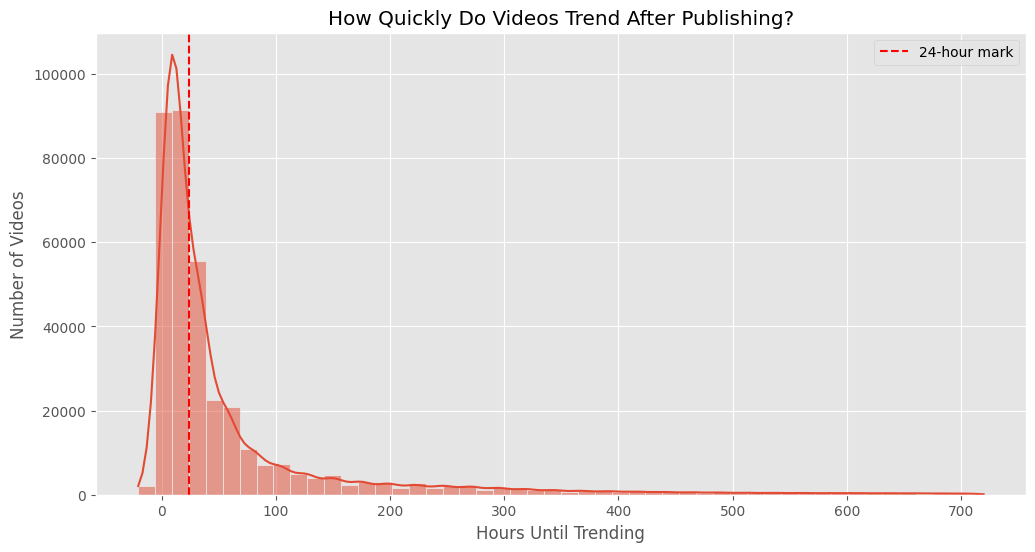

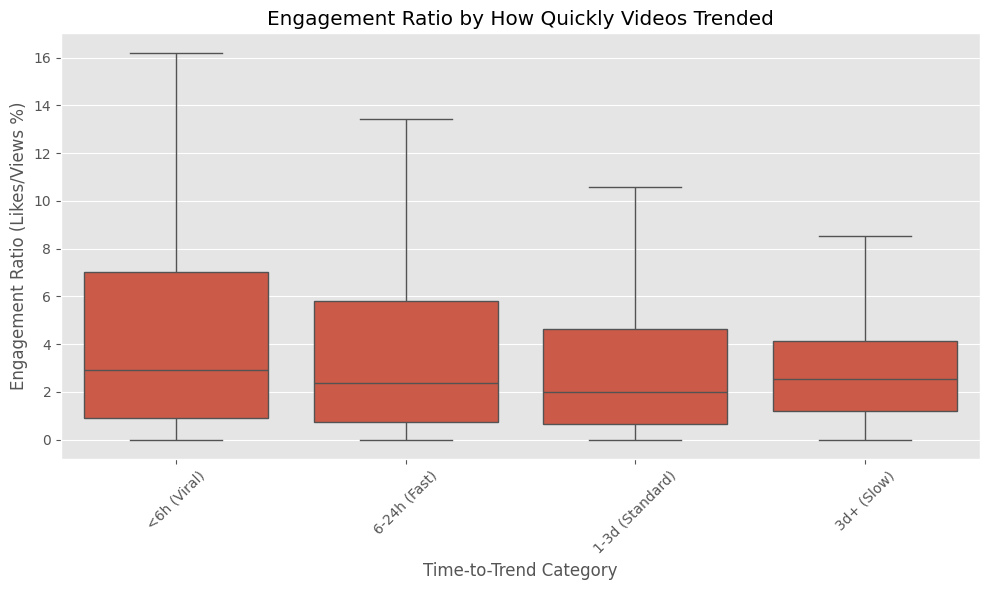


Median Performance by Trend Speed:
                    views    likes  comment_count  engagement_ratio
trend_speed                                                        
<6h (Viral)       62137.0   1539.0          247.0          2.920343
6-24h (Fast)      84522.5   1754.0          272.0          2.358185
1-3d (Standard)  283655.0   4986.0          703.0          1.982271
3d+ (Slow)       905232.0  20563.0         2027.0          2.556457


<ipython-input-29-6891e323ab3a>:54: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [ ]:
working_df = merged_df.copy()

# Fix timezone issues
working_df['publish_time'] = pd.to_datetime(working_df['publish_time']).dt.tz_localize(None)
working_df['trending_date'] = pd.to_datetime(working_df['trending_date']).dt.tz_localize(None)

# Calculate time-to-trend
working_df['time_to_trend'] = (
    (working_df['trending_date'] - working_df['publish_time']).dt.total_seconds() / 3600
)

#  Remove outliers (videos that trended after 30 days)
working_df = working_df[working_df['time_to_trend'] < 720]  # 30 days

# Calculate engagement ratio
if 'engagement_ratio' not in working_df.columns:
    working_df['engagement_ratio'] = (working_df['likes'] / working_df['views']) * 100

# Bin into time groups
working_df['trend_speed'] = pd.cut(
    working_df['time_to_trend'],
    bins=[0, 6, 24, 72, 720],
    labels=['<6h (Viral)', '6-24h (Fast)', '1-3d (Standard)', '3d+ (Slow)']
)

#  Distribution of time-to-trend
plt.figure(figsize=(12, 6))
sns.histplot(data=working_df, x='time_to_trend', bins=50, kde=True)
plt.axvline(x=24, color='red', linestyle='--', label='24-hour mark')
plt.title("How Quickly Do Videos Trend After Publishing?")
plt.xlabel("Hours Until Trending")
plt.ylabel("Number of Videos")
plt.legend()
plt.show()

#  Engagement by trend speed
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=working_df,
    x='trend_speed',
    y='engagement_ratio',
    order=['<6h (Viral)', '6-24h (Fast)', '1-3d (Standard)', '3d+ (Slow)'],
    showfliers=False
)
plt.title("Engagement Ratio by How Quickly Videos Trended")
plt.xlabel("Time-to-Trend Category")
plt.ylabel("Engagement Ratio (Likes/Views %)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Additional analysis: Median metrics by trend speed
print("\nMedian Performance by Trend Speed:")
print(working_df.groupby('trend_speed')[['views', 'likes', 'comment_count', 'engagement_ratio']].median())

The Insights we can get are as follows:                                                       

For immediate impact:

Create short, highly engaging content to trigger the <6h viral boost.


For sustained growth:

Invest in high-quality, evergreen content that trends slowly but reaches massive audiences.


Engagement matters most for fast-trending:

The 2.92% engagement ratio for <6h videos suggests YouTube rewards early interaction.

Action: Ask for likes/comments in first 30 seconds.

Slow-trending videos dominate absolute numbers:

Despite lower engagement ratios, their sheer scale makes them valuable.

## Required Questions to Answer

### 1. How are engagement metrics (views, likes and dislikes) distributed overall and across different video categories?


Overall Statistics for Engagement Metrics:
              views          likes       dislikes  comment_count
count  3.633430e+05  363343.000000  363343.000000  363343.000000
mean   1.024412e+06   31192.477646    1408.550262    3236.374237
std    2.849075e+06   85222.312665    4211.193888    8444.943296
min    1.170000e+02       0.000000       0.000000       0.000000
25%    4.628750e+04     673.000000      41.000000     109.000000
50%    1.762380e+05    3516.000000     179.000000     518.000000
75%    6.497480e+05   17851.500000     753.000000    2046.000000
max    2.051770e+07  584054.590000   30749.950000   57988.450000


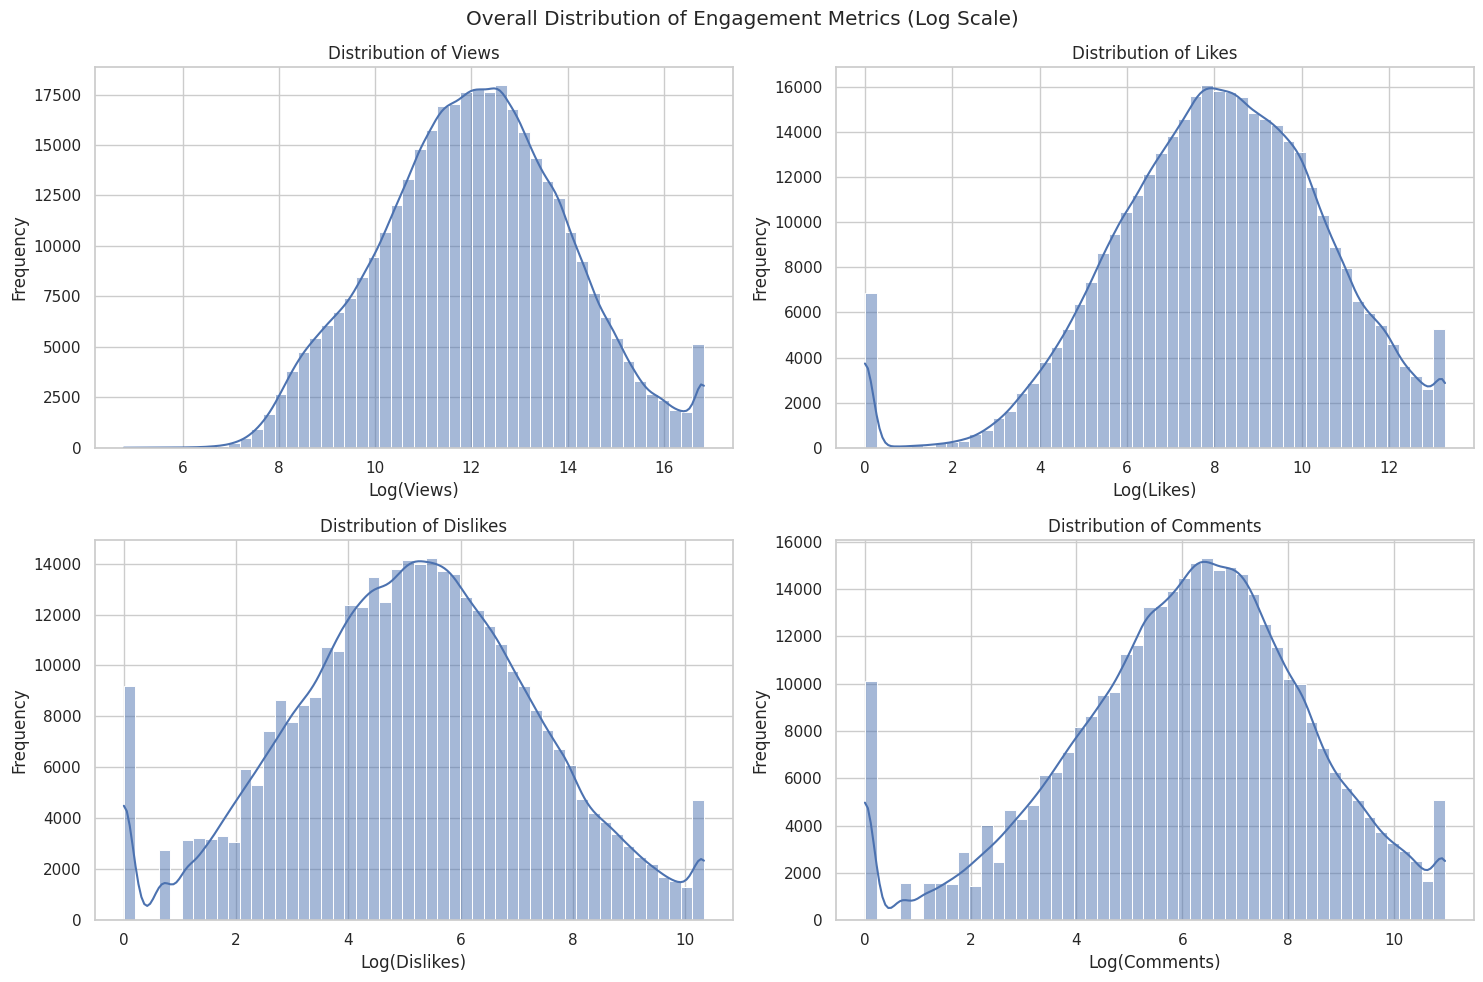


Top Categories by Total Views:
                         views_sum  video_count
category_id                                    
Music                 1.548814e+11        41439
Entertainment         8.696712e+10       104554
Film & Animation      2.537378e+10        20193
Comedy                2.126016e+10        26077
People & Blogs        2.097582e+10        52297
Sports                1.849392e+10        23034
News & Politics       9.900001e+09        35746
Howto & Style         9.554685e+09        18554
Science & Technology  8.602508e+09         8068
Gaming                7.542901e+09        11063


<ipython-input-30-c27fb77d8448>:61: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

<ipython-input-30-c27fb77d8448>:65: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

<ipython-input-30-c27fb77d8448>:69: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



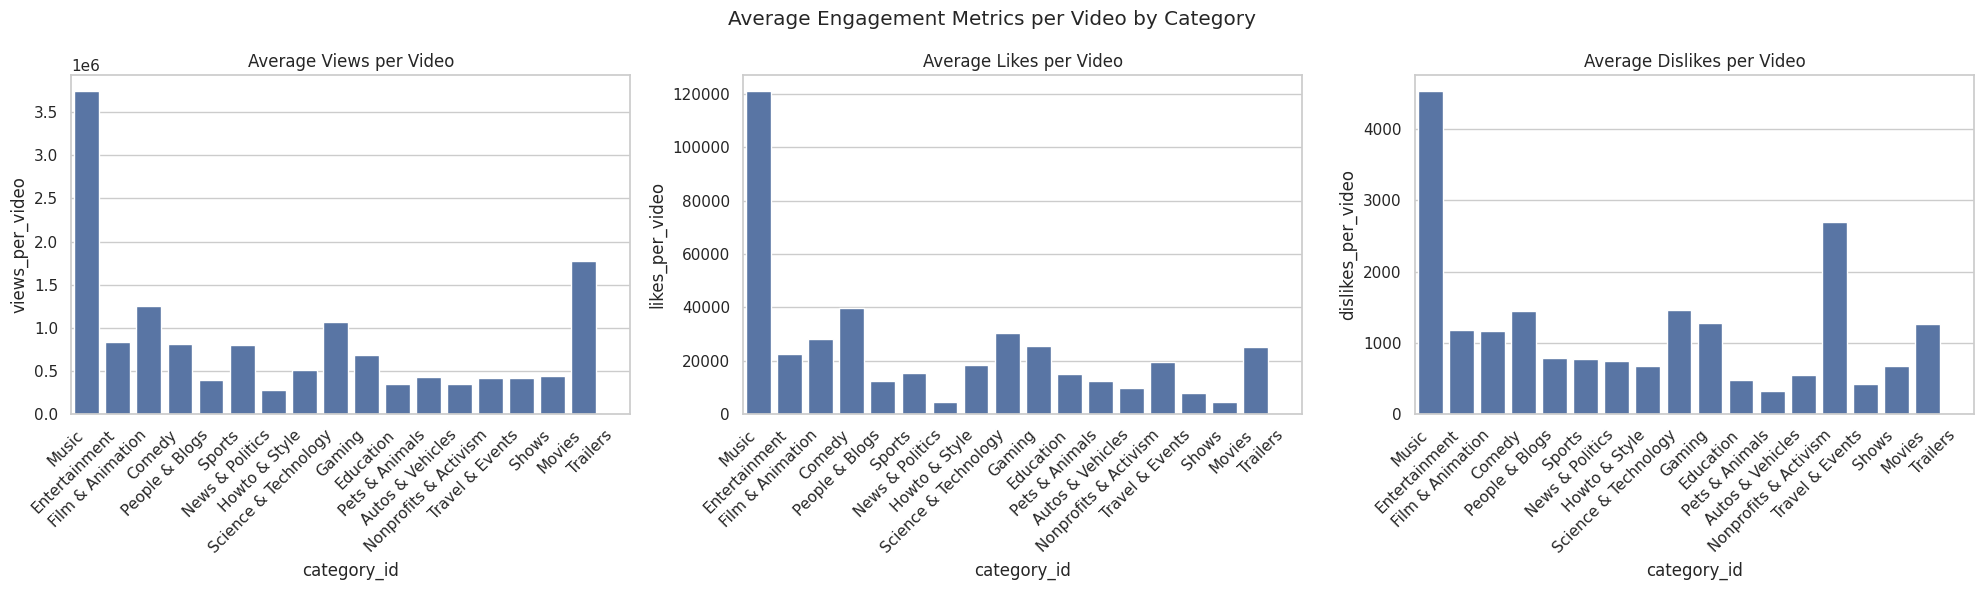

In [ ]:

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Convert date columns to datetime
merged_df['trending_date'] = pd.to_datetime(merged_df['trending_date'], format='%y.%d.%m')
merged_df['publish_time'] = pd.to_datetime(merged_df['publish_time'])

# Overall Distribution of Engagement Metrics
print("\nOverall Statistics for Engagement Metrics:")
print(merged_df[['views', 'likes', 'dislikes', 'comment_count']].describe())

# Plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Overall Distribution of Engagement Metrics (Log Scale)')

metrics = ['views', 'likes', 'dislikes', 'comment_count']
titles = ['Views', 'Likes', 'Dislikes', 'Comments']

for ax, metric, title in zip(axes.flatten(), metrics, titles):
    sns.histplot(np.log1p(merged_df[metric]), bins=50, kde=True, ax=ax)
    ax.set_title(f'Distribution of {title}')
    ax.set_xlabel(f'Log({title})')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Engagement Metrics by Video Category
# Calculate metrics by category
category_stats = merged_df.groupby('category_id').agg({
    'views': ['mean', 'median', 'sum'],
    'likes': ['mean', 'median', 'sum'],
    'dislikes': ['mean', 'median', 'sum'],
    'comment_count': ['mean', 'median', 'sum'],
    'video_id': 'count'
})


category_stats.columns = ['_'.join(col).strip() for col in category_stats.columns.values]
category_stats = category_stats.rename(columns={'video_id_count': 'video_count'})
category_stats = category_stats.sort_values('views_sum', ascending=False)

# Map category_id to category names

category_stats.index = category_stats.index.map(lambda cid: category_map.get(cid, f"ID {cid}"))

print("\nTop Categories by Total Views:")
print(category_stats[['views_sum', 'video_count']].head(10))

# Normalized engagement metrics (per video)
category_stats['views_per_video'] = category_stats['views_sum'] / category_stats['video_count']
category_stats['likes_per_video'] = category_stats['likes_sum'] / category_stats['video_count']
category_stats['dislikes_per_video'] = category_stats['dislikes_sum'] / category_stats['video_count']

# Plot normalized metrics
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Average Engagement Metrics per Video by Category')

sns.barplot(x=category_stats.index, y=category_stats['views_per_video'], ax=axes[0])
axes[0].set_title('Average Views per Video')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

sns.barplot(x=category_stats.index, y=category_stats['likes_per_video'], ax=axes[1])
axes[1].set_title('Average Likes per Video')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

sns.barplot(x=category_stats.index, y=category_stats['dislikes_per_video'], ax=axes[2])
axes[2].set_title('Average Dislikes per Video')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


### 2. Which YouTube channels and video categories trend the most in each country and globally?


GLOBAL TRENDING ANALYSIS:

Top 10 Most Trending Channels Globally:
channel_title
the late show with stephen colbert        971
wwe                                       787
late night with seth meyers               770
theellenshow                              737
the tonight show starring jimmy fallon    700
jimmy kimmel live                         697
vikatantv                                 687
pewdiepie                                 645
radaanmedia                               601
the late late show with james corden      579
Name: count, dtype: int64

Top 10 Most Trending Categories Globally:
category_id
Entertainment           104554
People & Blogs           52297
Music                    41439
News & Politics          35746
Comedy                   26077
Sports                   23034
Film & Animation         20193
Howto & Style            18554
Gaming                   11063
Science & Technology      8068
Name: count, dtype: int64

COUNTRY-WISE TRENDING ANALYSIS:
Total co

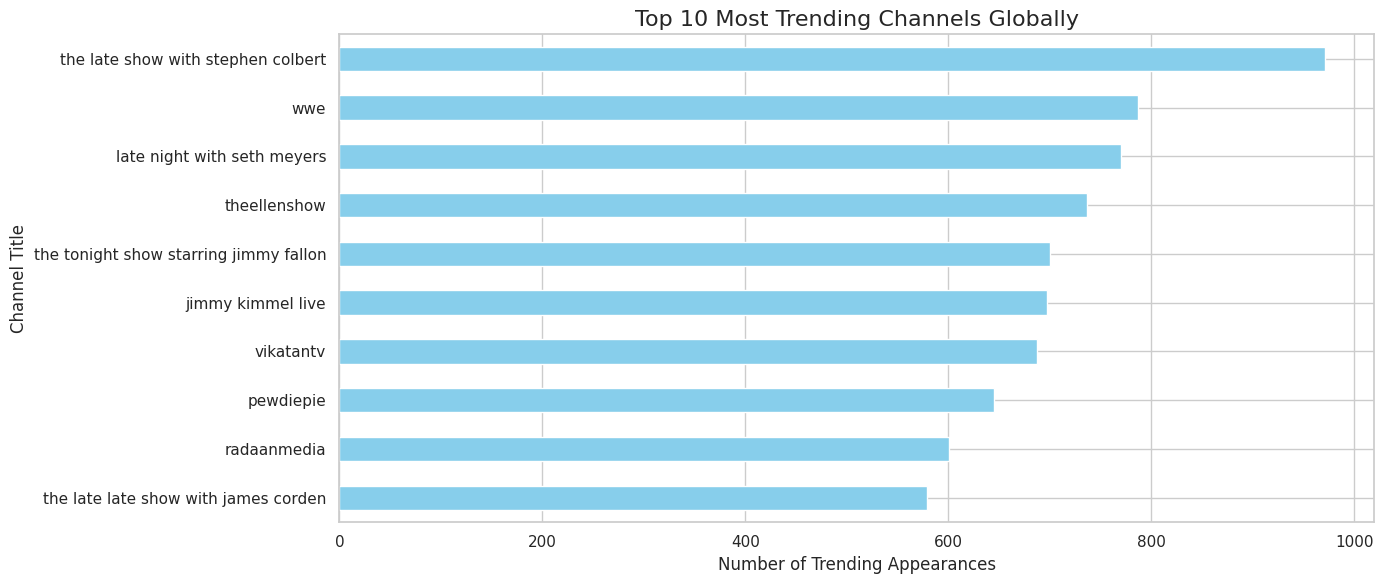

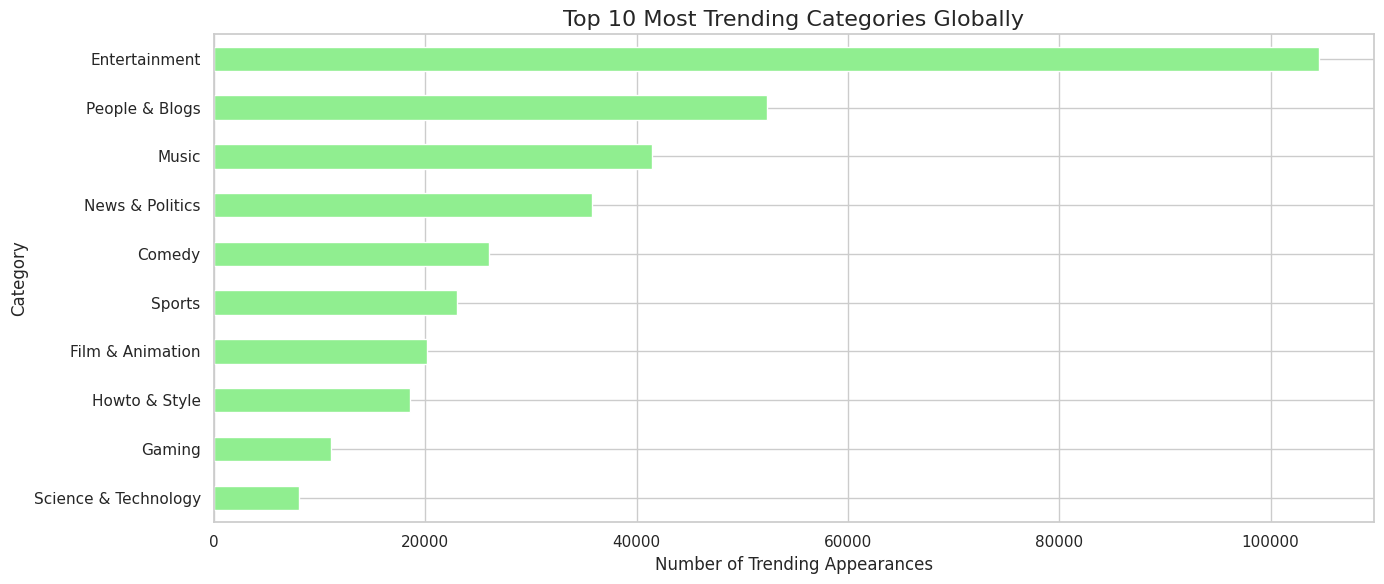

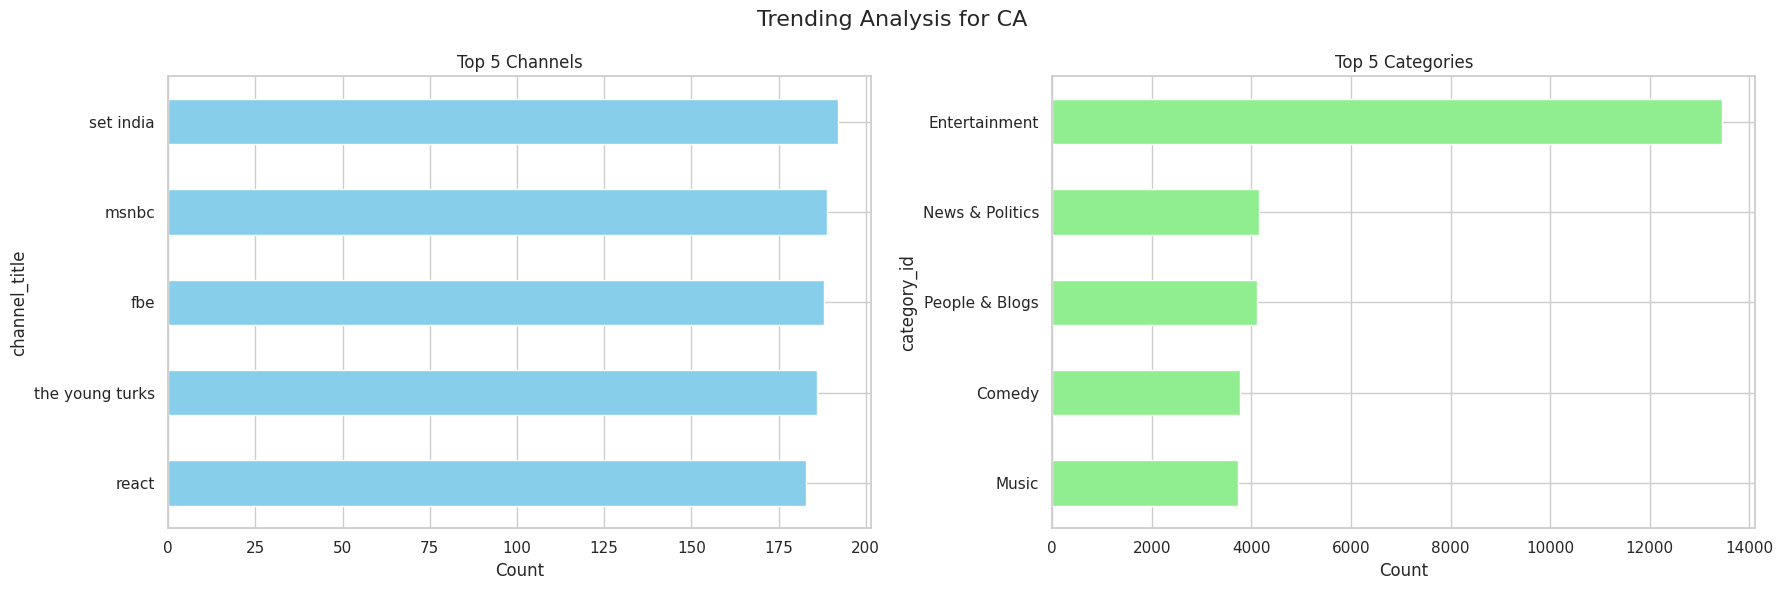

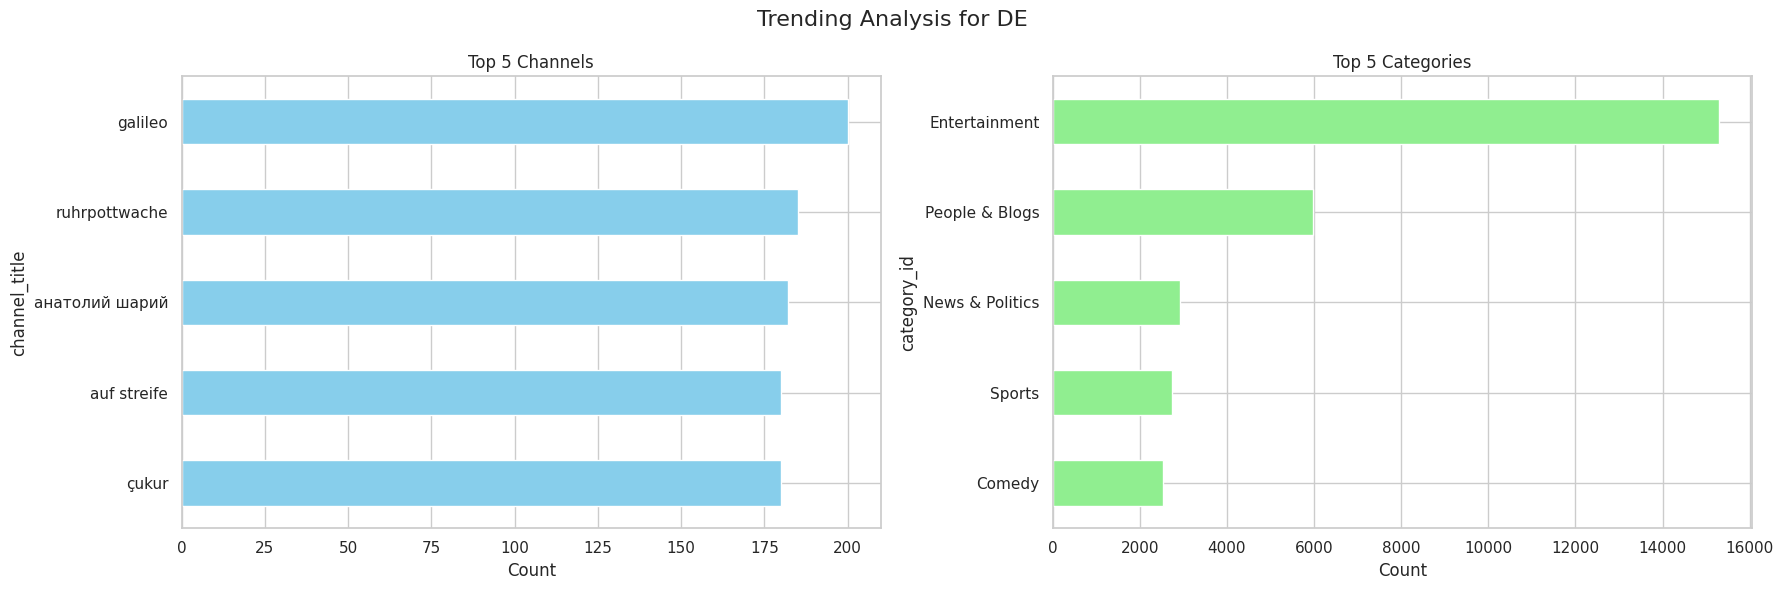

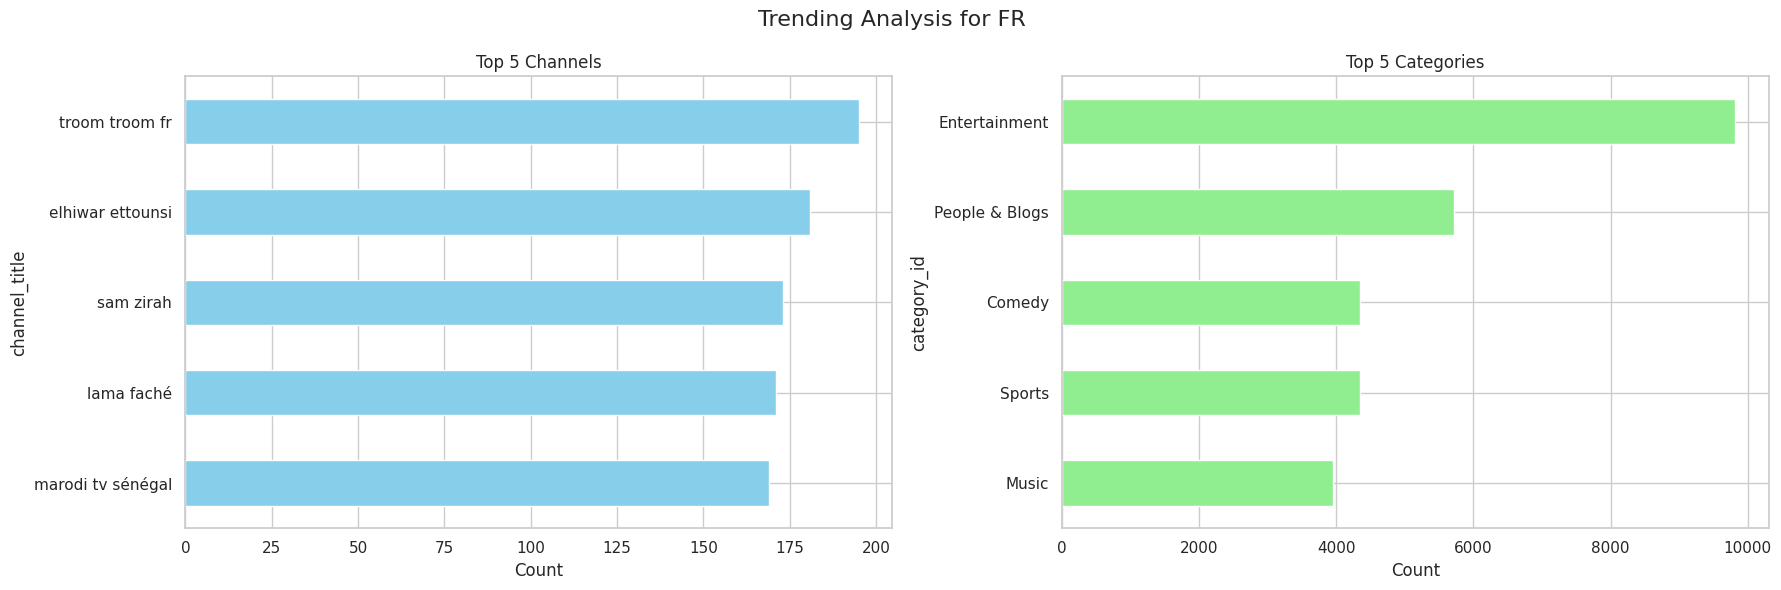

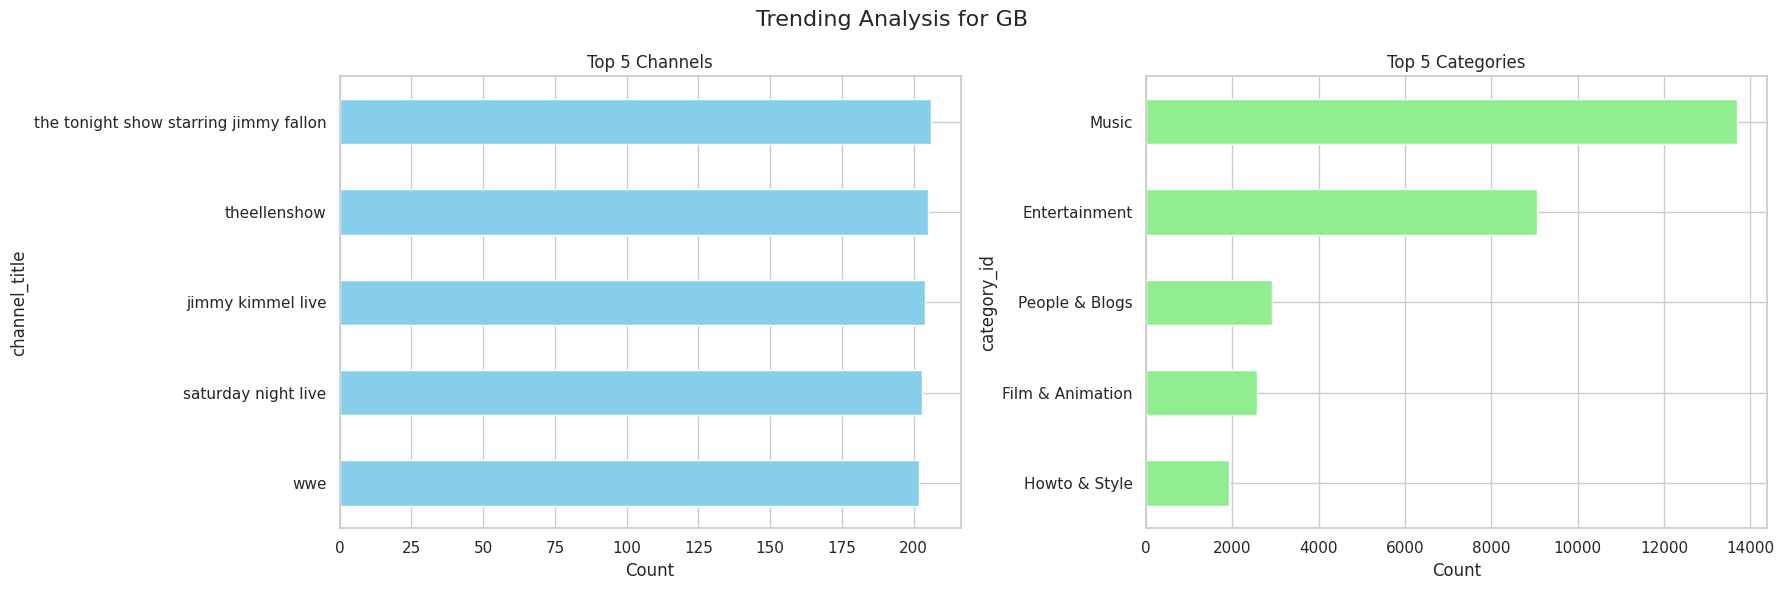

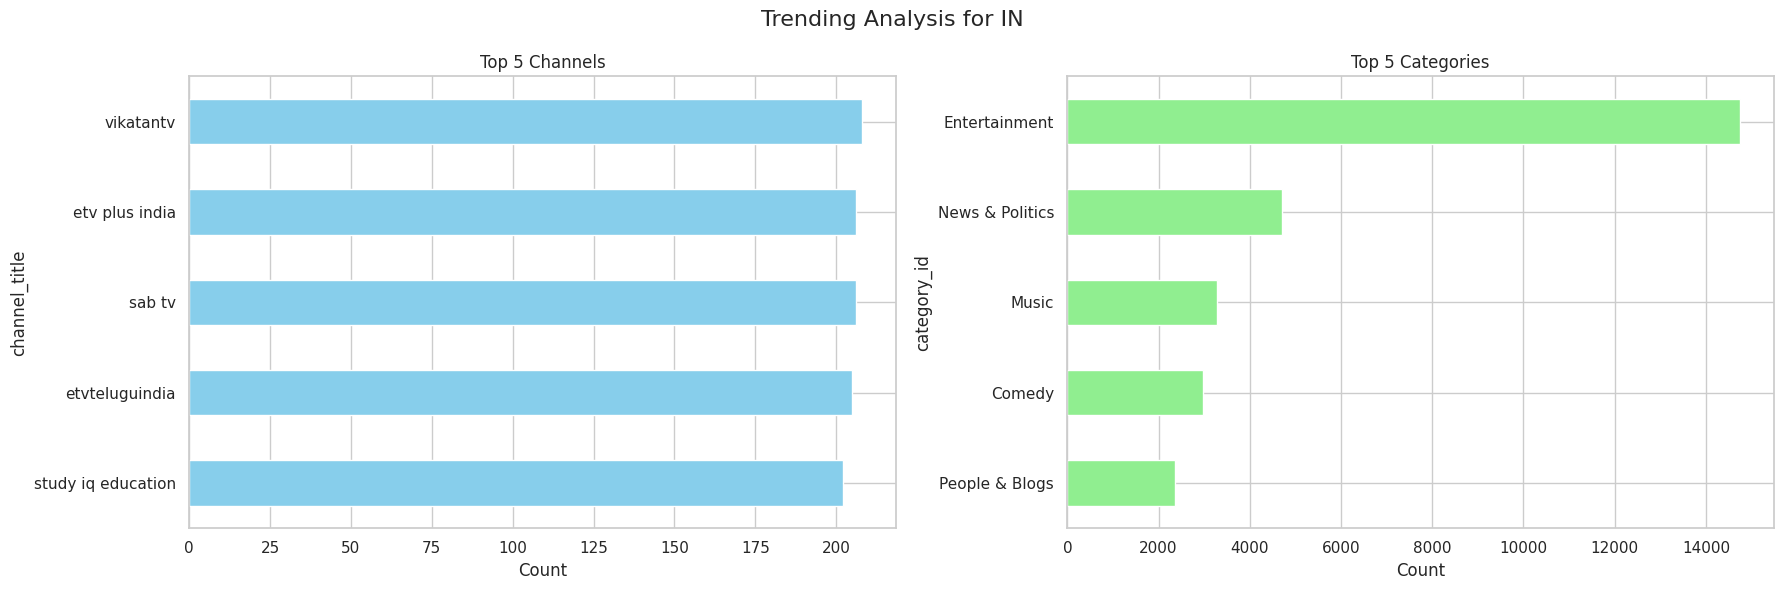

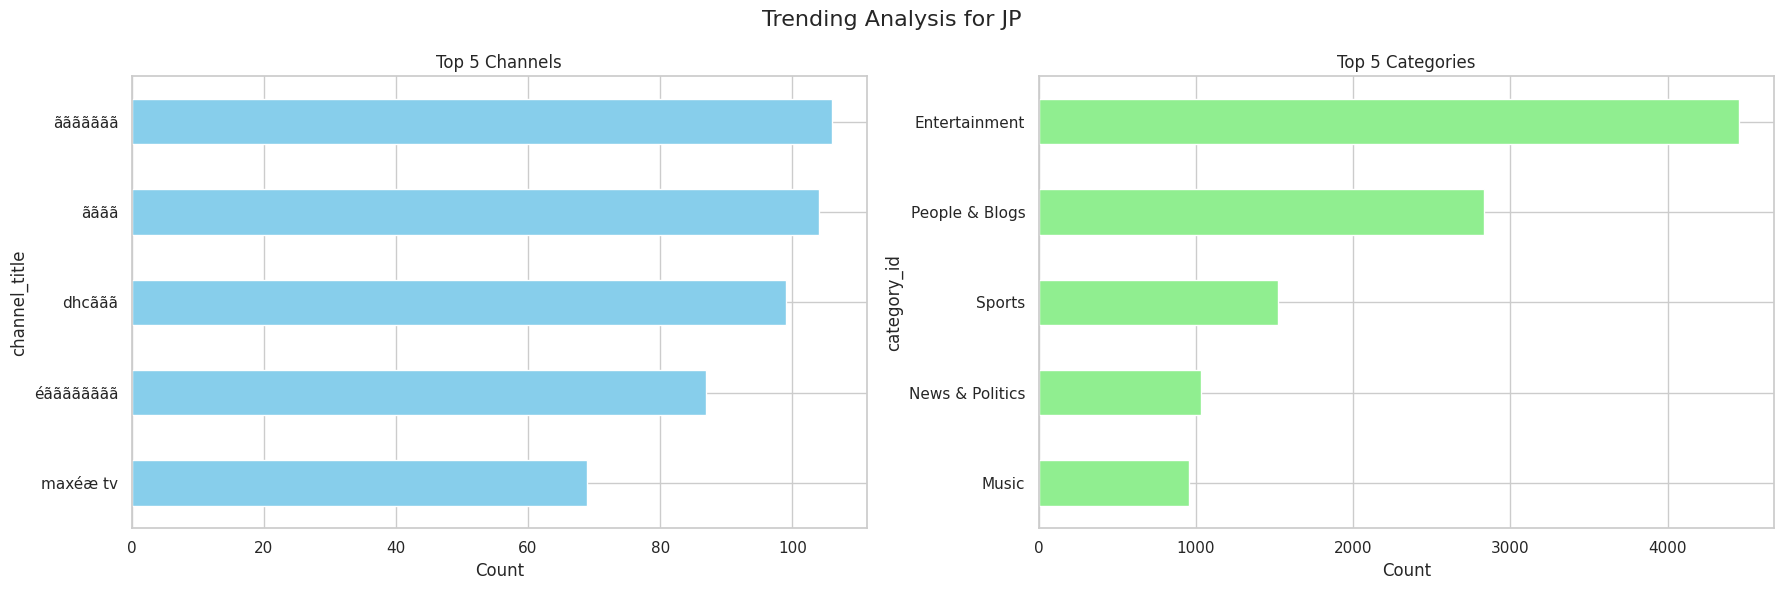

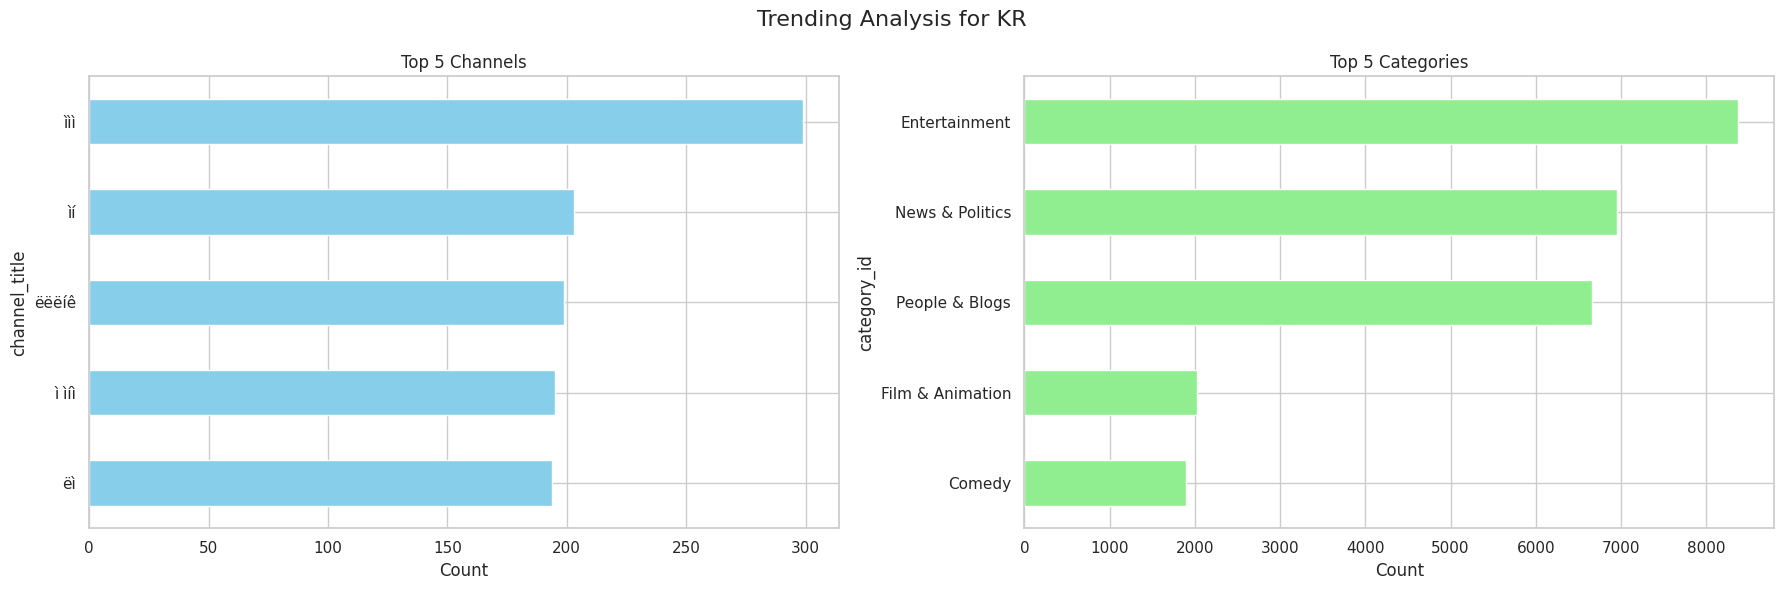

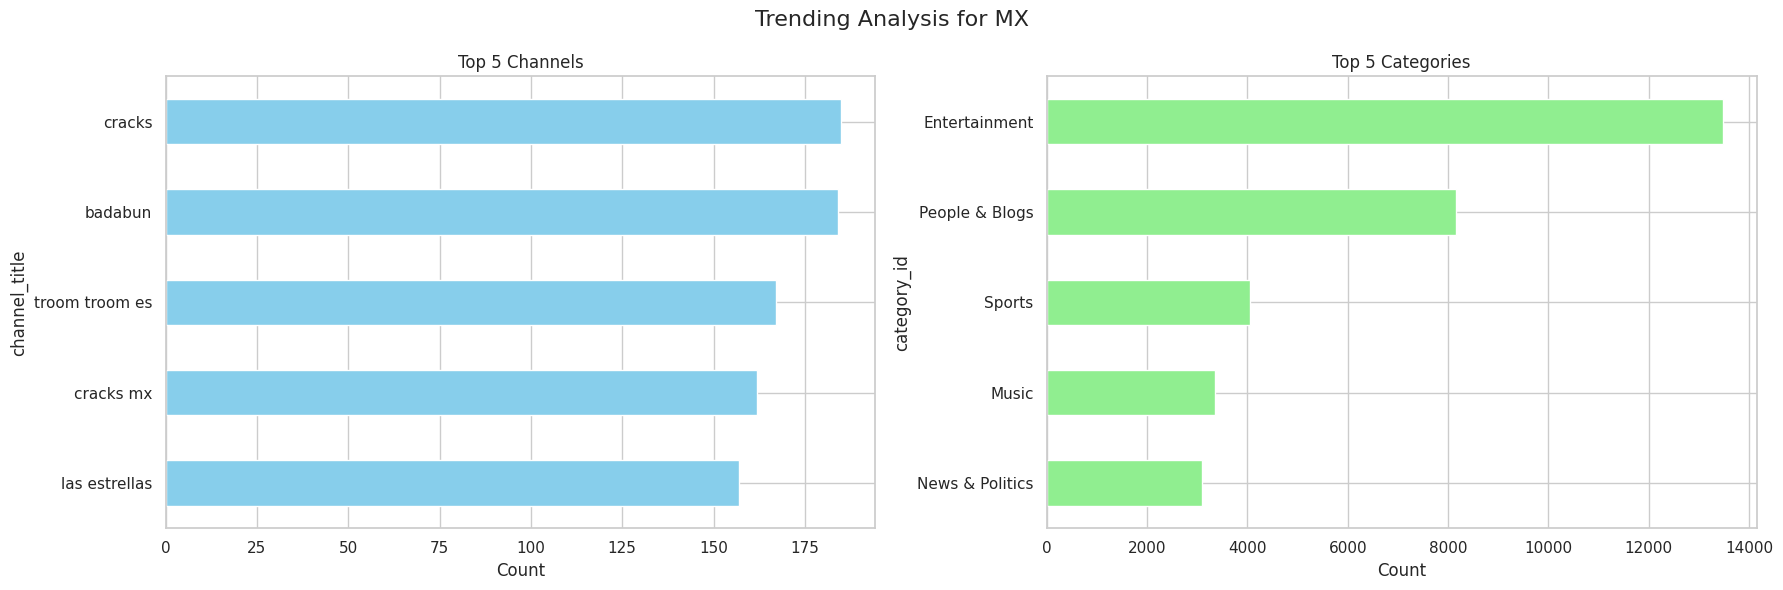

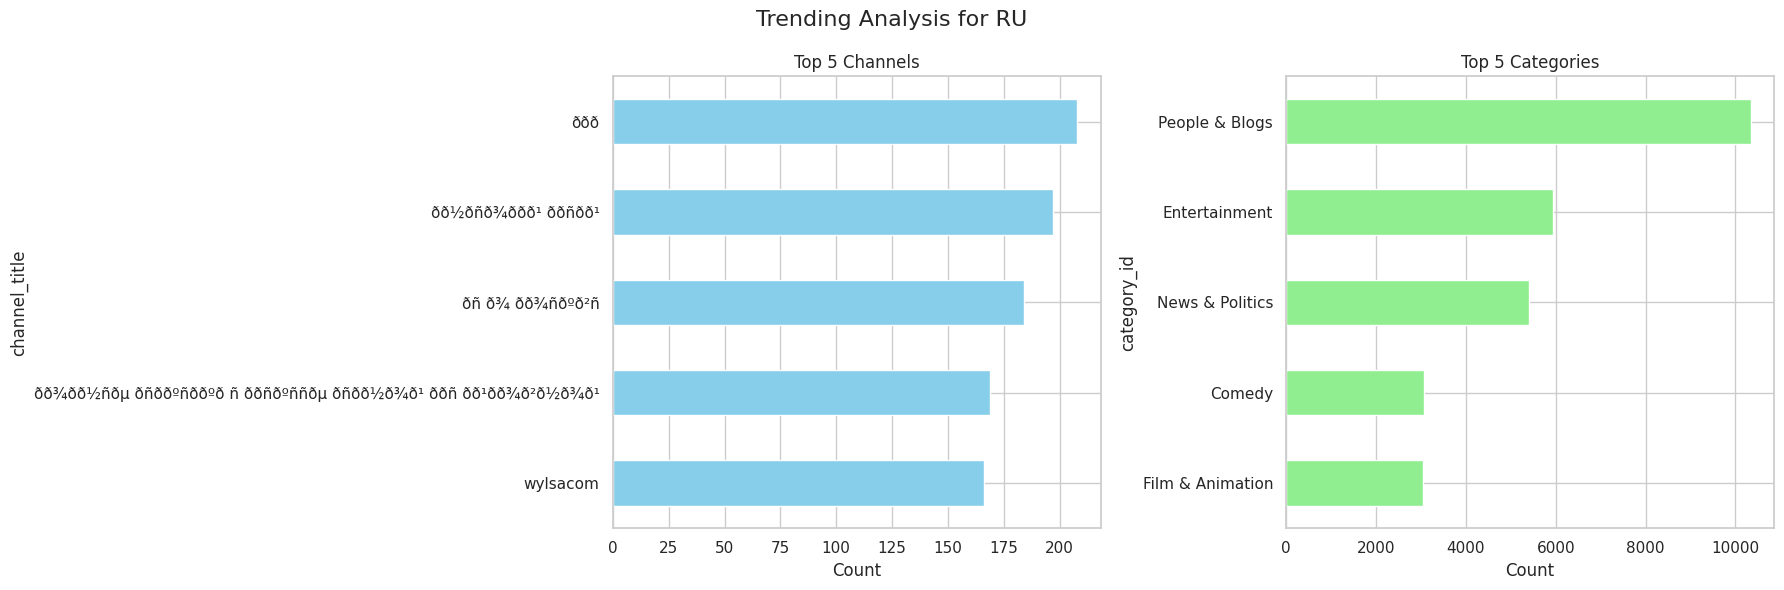

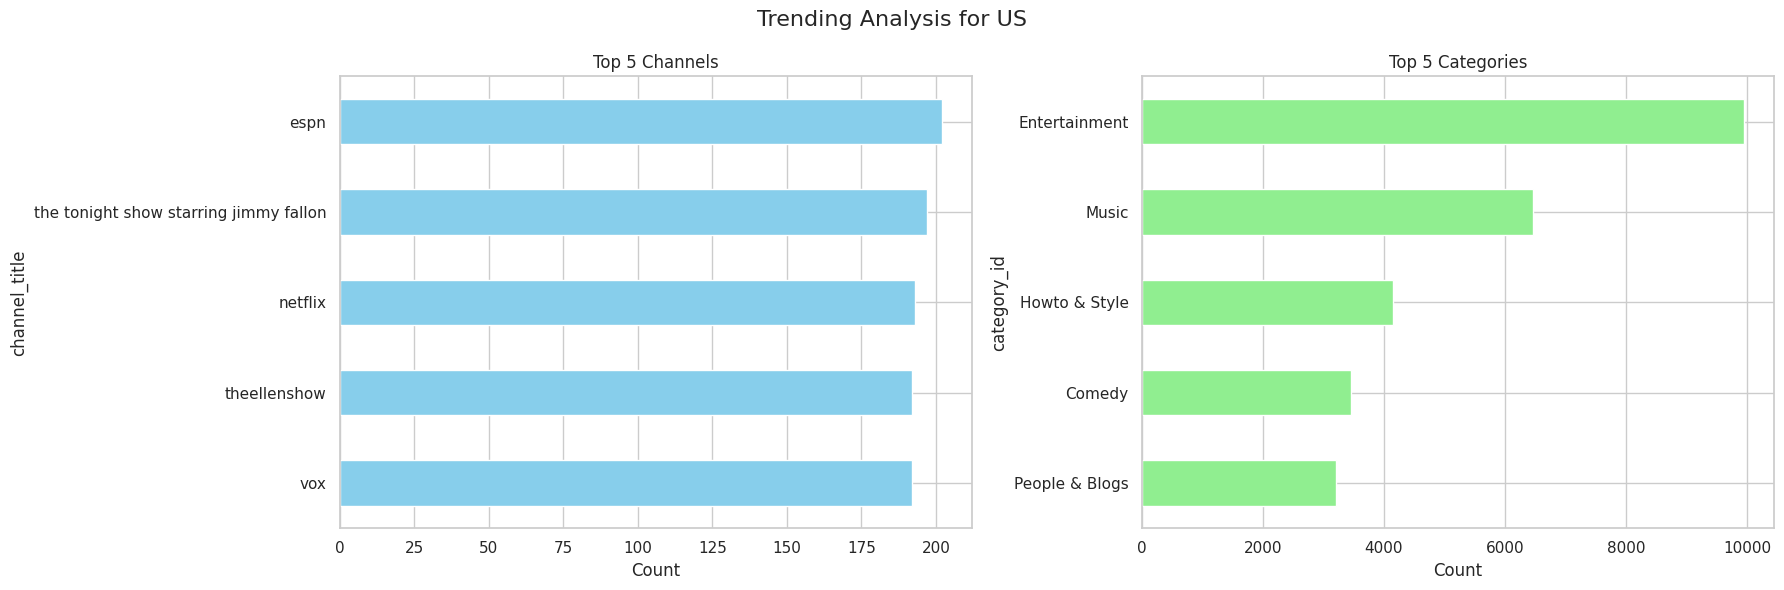

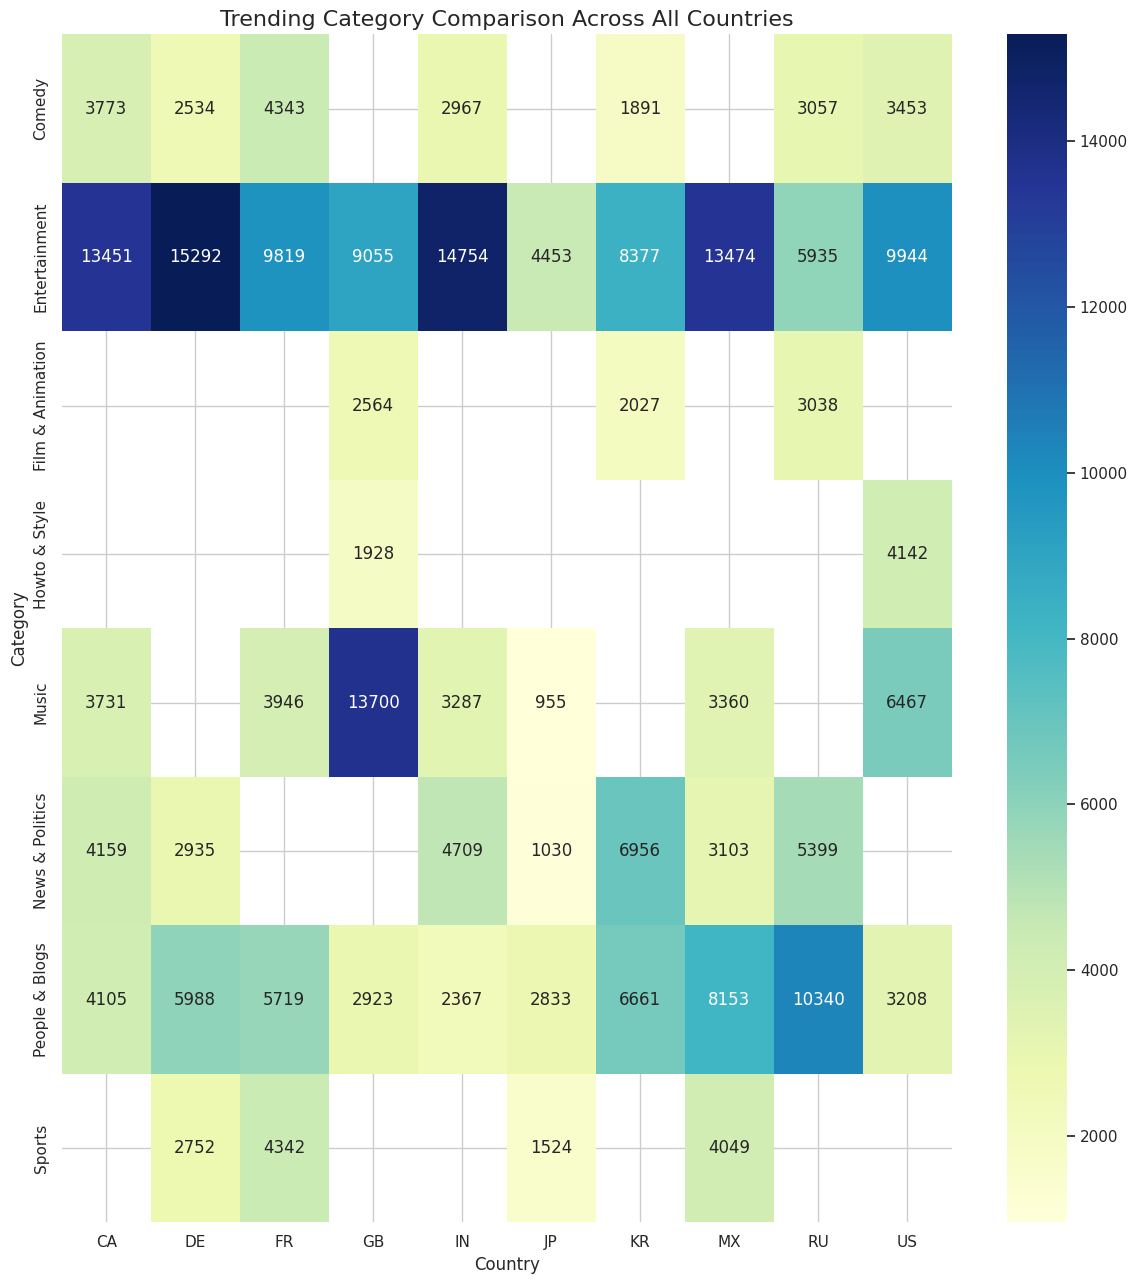

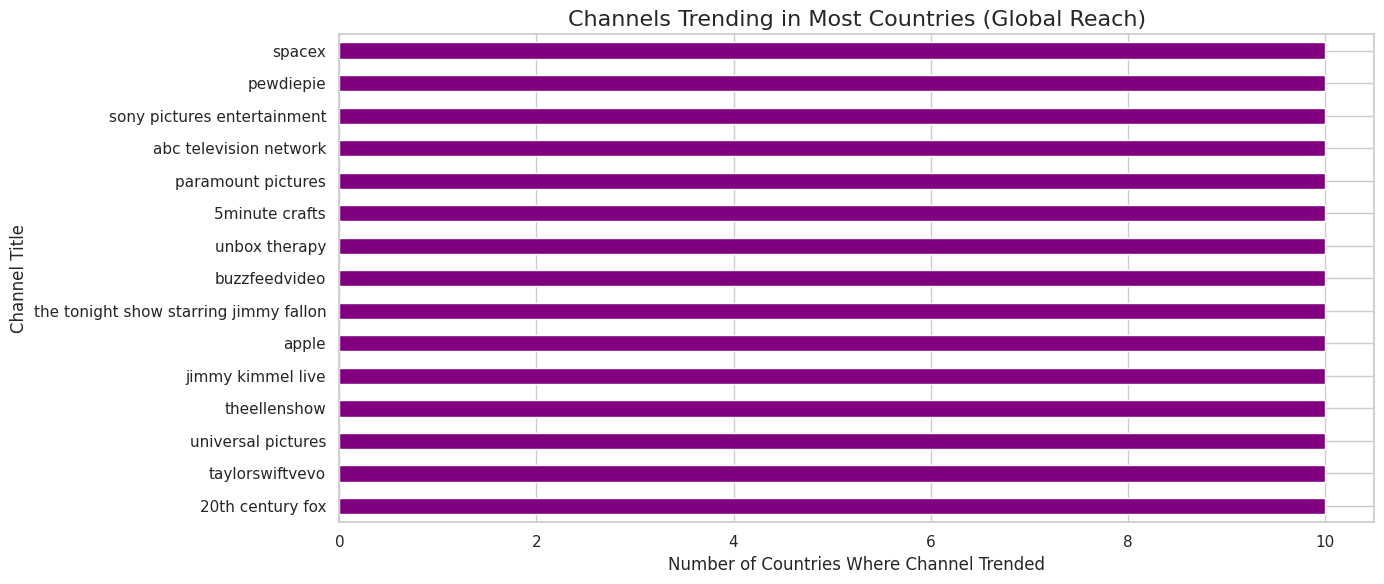

In [ ]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Global Analysis
print("\nGLOBAL TRENDING ANALYSIS:")
print("="*50)

# Most trending channels globally
global_channels = merged_df['channel_title'].value_counts().head(10)
print("\nTop 10 Most Trending Channels Globally:")
print(global_channels)

# Most trending categories globally (map IDs to names)
global_categories = merged_df['category_id'].value_counts().head(10)
global_category_names = global_categories.index.map(lambda cid: category_map.get(cid, f"ID {cid}"))
global_categories.index = global_category_names

print("\nTop 10 Most Trending Categories Globally:")
print(global_categories)

# Country-wise Analysis
print("\nCOUNTRY-WISE TRENDING ANALYSIS:")
print("="*50)

countries = merged_df['country'].unique()
n_countries = len(countries)
print(f"Total countries in dataset: {n_countries}")

country_results = {}

for country in countries:
    country_df = merged_df[merged_df['country'] == country]

    # Top channels and categories
    top_channels = country_df['channel_title'].value_counts().head(5)
    top_categories = country_df['category_id'].value_counts().head(5)

    # Map category IDs to names
    top_categories.index = top_categories.index.map(lambda cid: category_map.get(cid, f"ID {cid}"))

    country_results[country] = {
        'top_channels': top_channels,
        'top_categories': top_categories
    }

    print(f"\nCountry: {country}")
    print("\nTop 5 Trending Channels:")
    print(top_channels)
    print("\nTop 5 Trending Categories:")
    print(top_categories)

#  Visualization of Global Trends
plt.figure(figsize=(14, 6))
global_channels.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 10 Most Trending Channels Globally', fontsize=16)
plt.xlabel('Number of Trending Appearances', fontsize=12)
plt.ylabel('Channel Title', fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
global_categories.sort_values().plot(kind='barh', color='lightgreen')
plt.title('Top 10 Most Trending Categories Globally', fontsize=16)
plt.xlabel('Number of Trending Appearances', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.tight_layout()
plt.show()

# Visualization of Country-wise Trends
for country in countries:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f'Trending Analysis for {country}', fontsize=16)

    # Top channels
    country_results[country]['top_channels'].sort_values().plot(
        kind='barh', ax=ax1, color='skyblue', title='Top 5 Channels')
    ax1.set_xlabel('Count')

    # Top categories (already mapped to names)
    country_results[country]['top_categories'].sort_values().plot(
        kind='barh', ax=ax2, color='lightgreen', title='Top 5 Categories')
    ax2.set_xlabel('Count')

    plt.tight_layout()
    plt.show()

# Comparative Analysis of Categories Across Countries
category_comparison = pd.DataFrame()

for country in countries:
    temp_df = pd.DataFrame({
        'country': country,
        'category': country_results[country]['top_categories'].index,
        'count': country_results[country]['top_categories'].values
    })
    category_comparison = pd.concat([category_comparison, temp_df])

# Pivot for heatmap
heatmap_data = category_comparison.pivot(index='category', columns='country', values='count')

plt.figure(figsize=(12, 8 + len(countries)//2))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='YlGnBu')
plt.title('Trending Category Comparison Across All Countries', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.tight_layout()
plt.show()




### 3. Are there seasonal or day-of-week patterns in trending videos? How does the upload day and time impact video engagement?

<ipython-input-32-025644f35dda>:30: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.




--- Seasonal Patterns by Month ---
               video_id         views         likes     dislikes  \
publish_month                                                      
January           50176  8.131296e+05  26531.622167  1272.367944   
February          51518  1.129751e+06  30536.660229  1344.342746   
March             56346  1.058234e+06  31757.043841  1391.465082   
April             44307  1.358270e+06  39912.584025  1783.425411   
May               53479  1.402397e+06  40031.194249  1834.477604   
June              18453  7.654840e+05  25728.140061  1163.366054   
July                 73  2.558968e+05   2224.410959    68.164384   
August              116  1.109191e+05    734.948276    64.103448   
September           143  1.835428e+05   3657.454545    67.517483   
October             212  3.805461e+05   5689.113208   267.301887   
November          34272  7.329420e+05  23881.318332   993.183043   
December          54248  7.192994e+05  26458.374971  1245.654165   

           

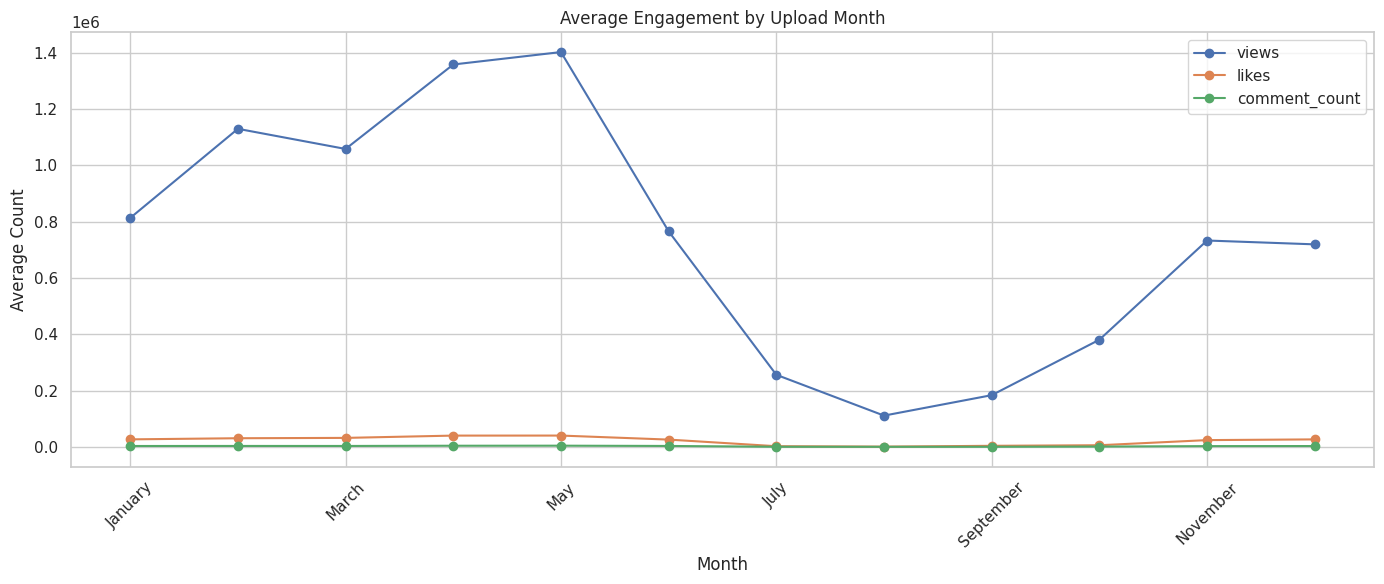

<ipython-input-32-025644f35dda>:50: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.




--- Day-of-Week Patterns ---
             video_id         views         likes     dislikes  comment_count
publish_day                                                                  
Monday          52662  9.748132e+05  27985.934851  1310.120158    2989.675899
Tuesday         51407  1.028122e+06  31281.648704  1374.316099    3352.870546
Wednesday       52127  1.026255e+06  30739.702114  1264.447152    3098.161279
Thursday        55688  1.188514e+06  36276.526889  1617.623198    3535.563252
Friday          60788  1.402961e+06  43489.201679  1876.467804    4078.460803
Saturday        44614  6.426255e+05  20152.561573  1043.057916    2490.713118
Sunday          46057  7.466793e+05  23588.894934  1206.073219    2793.975860


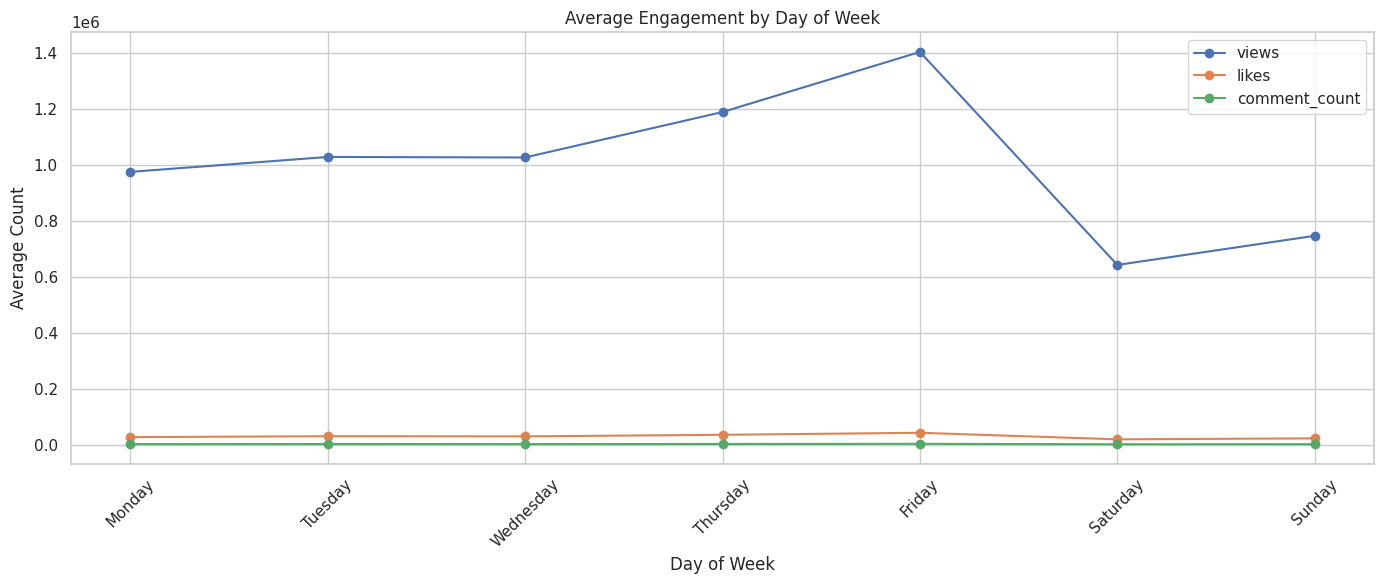


--- Hourly Upload Impact ---
              video_id         views         likes     dislikes  comment_count
publish_hour                                                                  
0                 9625  9.321301e+05  29059.837790  1231.627522    3310.484530
1                 9851  1.027147e+06  23839.077589  1523.939818    3374.632494
2                 9752  8.436182e+05  19478.234870   833.184542    2236.745268
3                10470  9.596605e+05  24084.305040  1234.501170    2550.260401
4                11250  2.166909e+06  56402.680145  2679.839307    4942.779080
5                11573  2.117558e+06  56144.123831  2555.995118    4497.357651
6                 8609  8.425213e+05  17197.076289  1045.078244    1797.329777
7                10116  9.403093e+05  21103.663227  1206.161106    2213.873067
8                12127  8.946592e+05  24478.756064  1210.891923    2433.656428
9                13785  1.077507e+06  40052.242100  1405.202227    3956.938778
10               13845

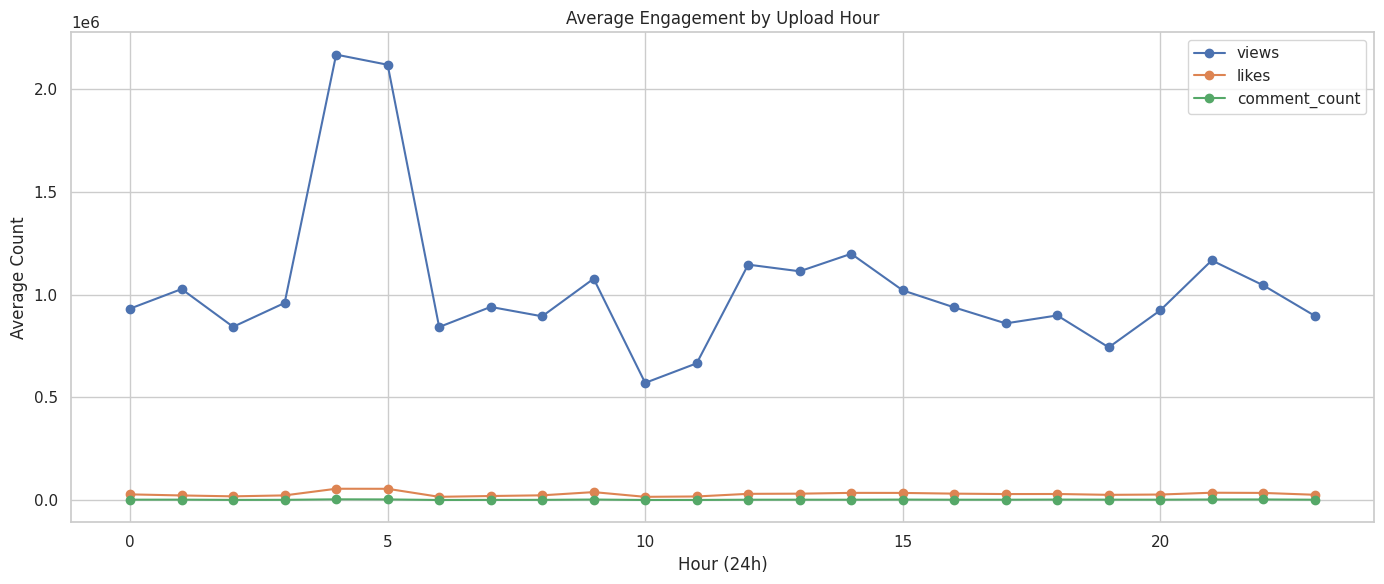

<ipython-input-32-025644f35dda>:92: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.




--- Engagement by Time Segment ---
                   video_id         views         likes     dislikes  \
time_segment                                                           
Night (0-6)           62521  1.379521e+06  35843.000096  1721.756092   
Afternoon (12-18)    136092  1.028390e+06  33324.119875  1441.797596   
Evening (18-24)       91150  9.388389e+05  30997.276303  1353.190233   
Morning (6-12)        73580  8.213241e+05  23540.097025  1149.504715   

                   comment_count  
time_segment                      
Night (0-6)          3539.211934  
Afternoon (12-18)    3244.883103  
Evening (18-24)      3692.154115  
Morning (6-12)       2398.700410  


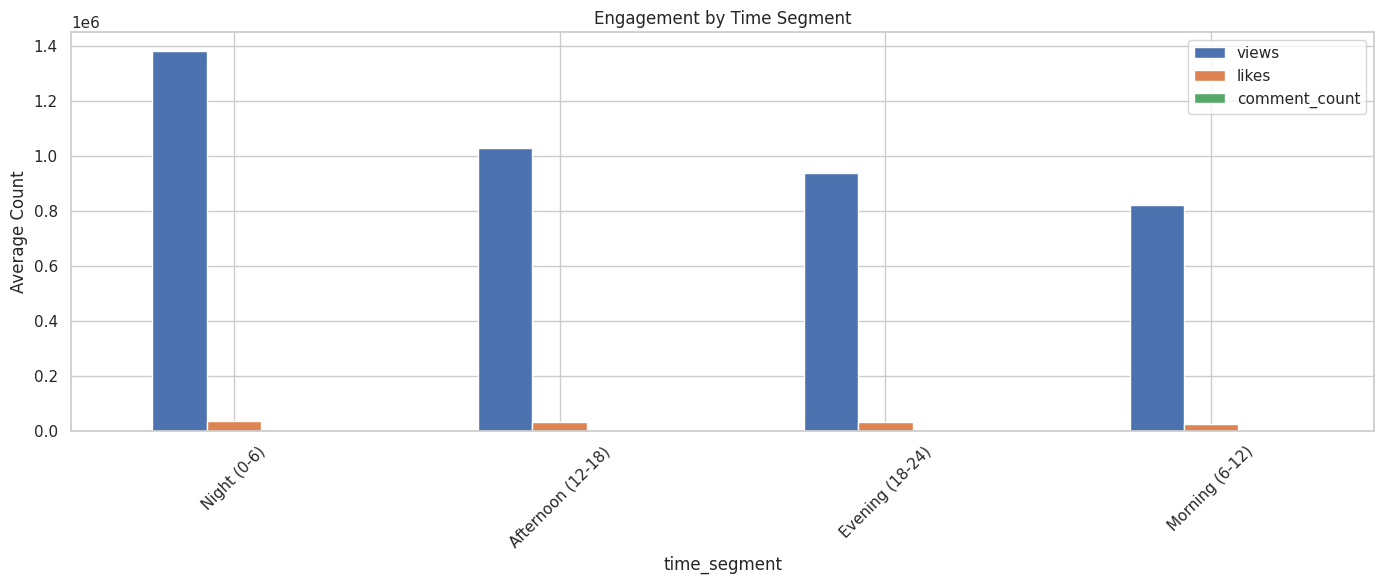

<ipython-input-32-025644f35dda>:111: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



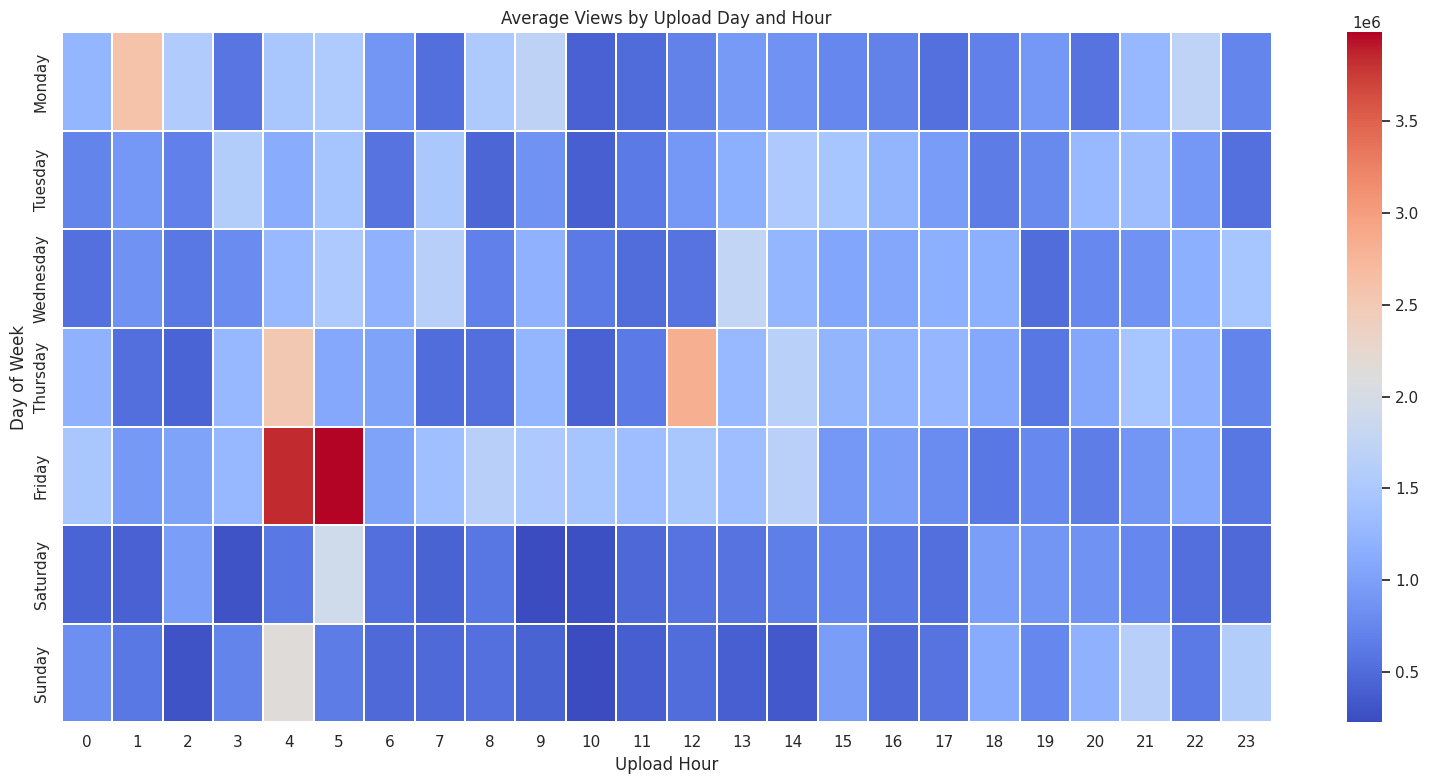

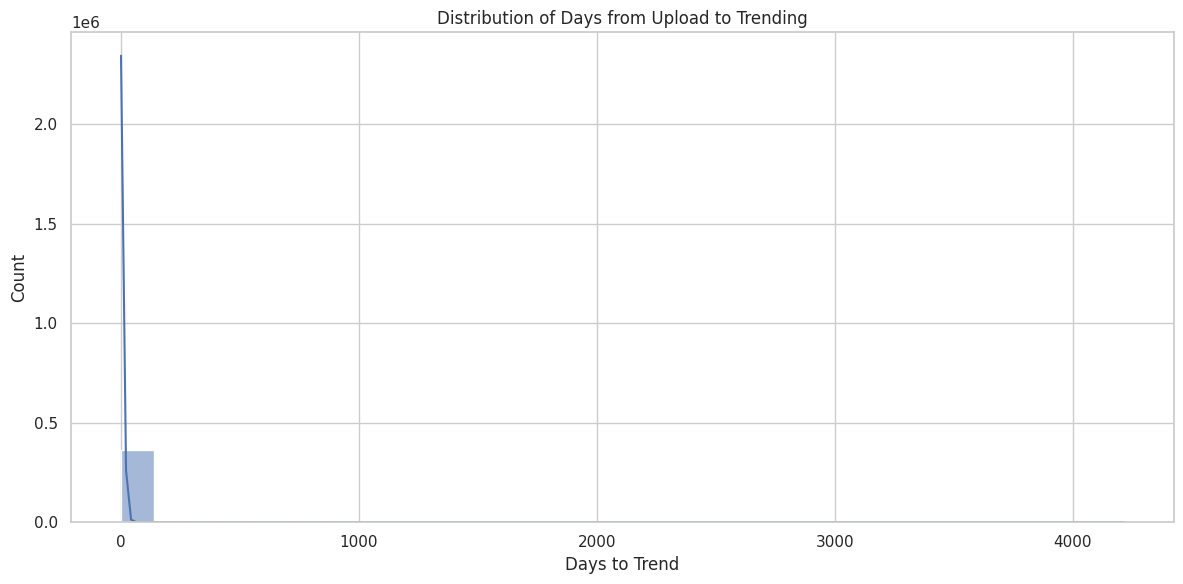


--- Average Days Between Upload and Trending ---
count    363343.000000
mean          7.697903
std          99.020863
min           0.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        4215.000000
Name: days_to_trend, dtype: float64


In [ ]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

# Convert date columns properly
merged_df['trending_date'] = pd.to_datetime(merged_df['trending_date'])
merged_df['publish_time'] = pd.to_datetime(merged_df['publish_time']).dt.tz_localize(None)

# Feature extraction
merged_df['publish_day'] = merged_df['publish_time'].dt.day_name()
merged_df['publish_month'] = merged_df['publish_time'].dt.month_name()
merged_df['publish_hour'] = merged_df['publish_time'].dt.hour
merged_df['days_to_trend'] = (merged_df['trending_date'] - merged_df['publish_time'].dt.normalize()).dt.days

# Categorical ordering
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
merged_df['publish_day'] = pd.Categorical(merged_df['publish_day'], categories=day_order, ordered=True)
merged_df['publish_month'] = pd.Categorical(merged_df['publish_month'], categories=month_order, ordered=True)

# TIME SEGMENTS
merged_df['time_segment'] = pd.cut(merged_df['publish_hour'],
                                   bins=[0, 6, 12, 18, 24],
                                   labels=['Night (0-6)', 'Morning (6-12)', 'Afternoon (12-18)', 'Evening (18-24)'],
                                   right=False)

# SEASONAL + DAY-OF-WEEK PATTERNS

# Monthly analysis
monthly = merged_df.groupby('publish_month').agg({
    'video_id': 'count',
    'views': 'mean',
    'likes': 'mean',
    'dislikes': 'mean',
    'comment_count': 'mean'
}).sort_index()

print("\n--- Seasonal Patterns by Month ---")
print(monthly)

monthly[['views', 'likes', 'comment_count']].plot(kind='line', marker='o')
plt.title('Average Engagement by Upload Month')
plt.xlabel('Month')
plt.ylabel('Average Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Day-of-week analysis
dow = merged_df.groupby('publish_day').agg({
    'video_id': 'count',
    'views': 'mean',
    'likes': 'mean',
    'dislikes': 'mean',
    'comment_count': 'mean'
}).sort_index()

print("\n--- Day-of-Week Patterns ---")
print(dow)

dow[['views', 'likes', 'comment_count']].plot(kind='line', marker='o')
plt.title('Average Engagement by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# HOUR + TIME-SEGMENT IMPACT ON ENGAGEMENT

# Hour of day
hourly = merged_df.groupby('publish_hour').agg({
    'video_id': 'count',
    'views': 'mean',
    'likes': 'mean',
    'dislikes': 'mean',
    'comment_count': 'mean'
})

print("\n--- Hourly Upload Impact ---")
print(hourly)

hourly[['views', 'likes', 'comment_count']].plot(marker='o')
plt.title('Average Engagement by Upload Hour')
plt.xlabel('Hour (24h)')
plt.ylabel('Average Count')
plt.grid(True)
plt.tight_layout()
plt.show()

# Time segment analysis
segment = merged_df.groupby('time_segment').agg({
    'video_id': 'count',
    'views': 'mean',
    'likes': 'mean',
    'dislikes': 'mean',
    'comment_count': 'mean'
}).sort_values('views', ascending=False)

print("\n--- Engagement by Time Segment ---")
print(segment)

segment[['views', 'likes', 'comment_count']].plot(kind='bar')
plt.title('Engagement by Time Segment')
plt.ylabel('Average Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#  COMBINED DAY + HOUR HEATMAP
pivot = merged_df.pivot_table(
    index='publish_day',
    columns='publish_hour',
    values='views',
    aggfunc='mean'
).reindex(index=day_order)

plt.figure(figsize=(16, 8))
sns.heatmap(pivot, cmap='coolwarm', linewidths=0.3)
plt.title('Average Views by Upload Day and Hour')
plt.xlabel('Upload Hour')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

#  TIME TO TREND
plt.figure(figsize=(12, 6))
sns.histplot(merged_df['days_to_trend'], bins=30, kde=True)
plt.title('Distribution of Days from Upload to Trending')
plt.xlabel('Days to Trend')
plt.tight_layout()
plt.show()

print("\n--- Average Days Between Upload and Trending ---")
print(merged_df['days_to_trend'].describe())


### 4. Do controversial videos, defined by a high dislike ratio, receive more engagement than universally liked ones?

<ipython-input-33-d29e31c90323>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-33-d29e31c90323>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




--- Engagement Stats by Controversy Level ---
                          video_id         views         likes     dislikes  \
controversy_level                                                             
Universally Liked (<10%)    265789  1.203798e+06  40261.847699  1344.217249   
Mixed (10%-30%)              71537  5.746111e+05   8069.041112  1450.088347   
Controversial (>30%)         19199  4.091137e+05   2873.960779  2644.603844   

                          comment_count  
controversy_level                        
Universally Liked (<10%)    3848.597911  
Mixed (10%-30%)             1695.290820  
Controversial (>30%)        1457.569754  


<Figure size 1400x600 with 0 Axes>

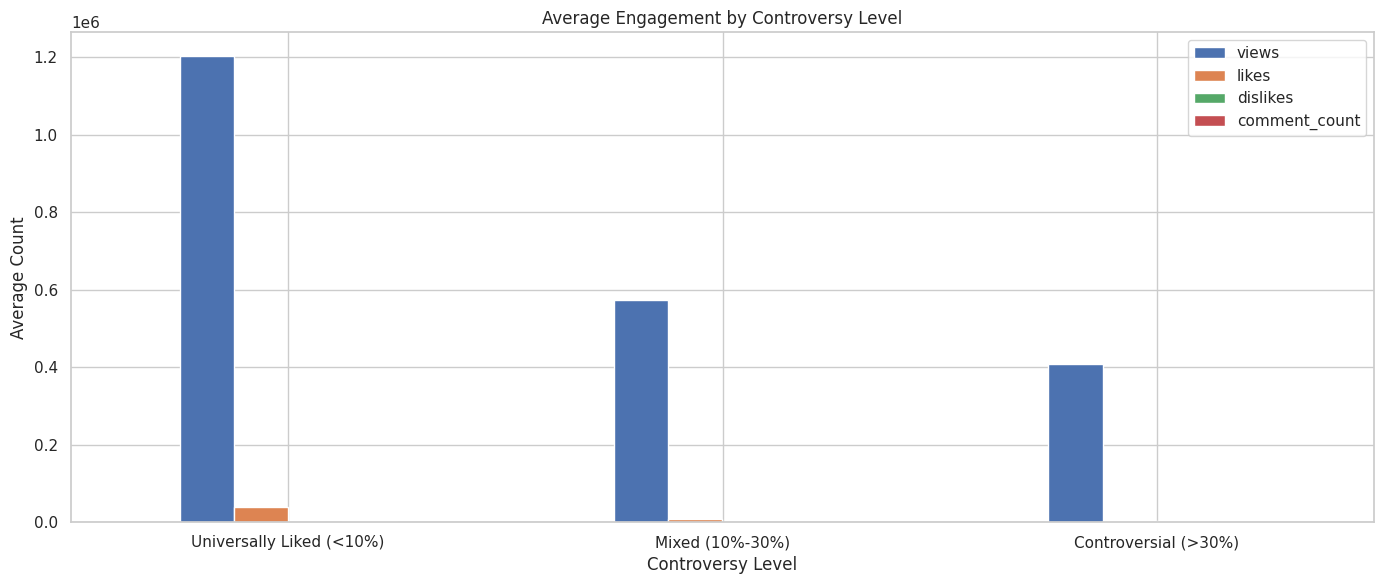

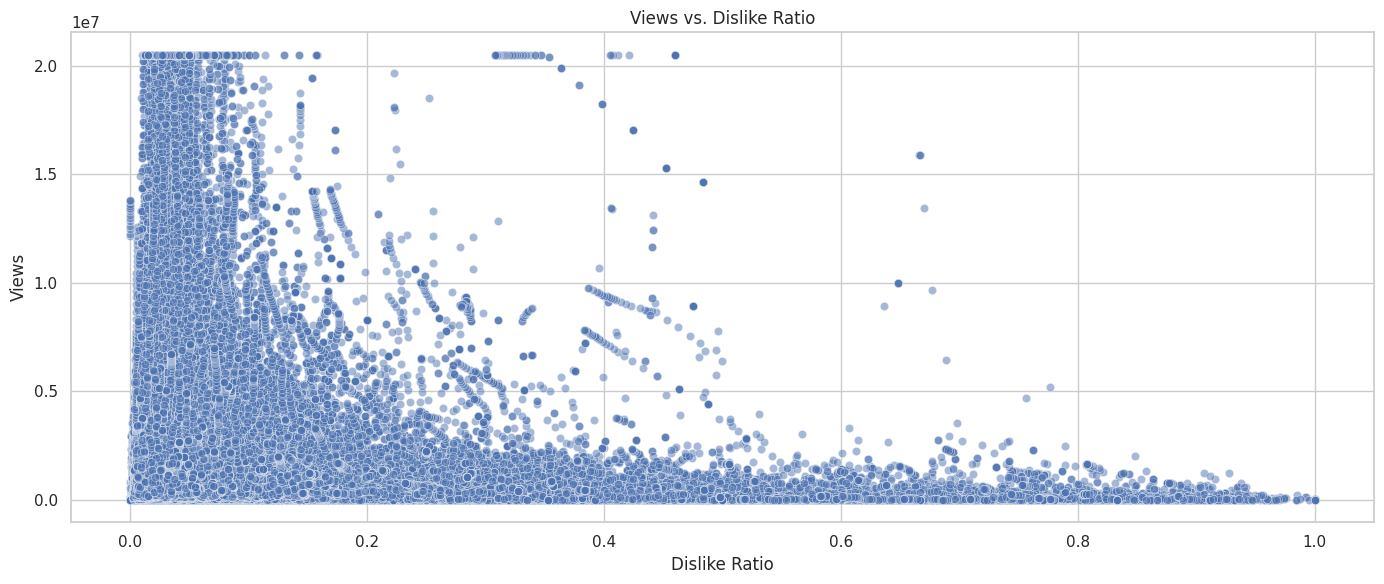

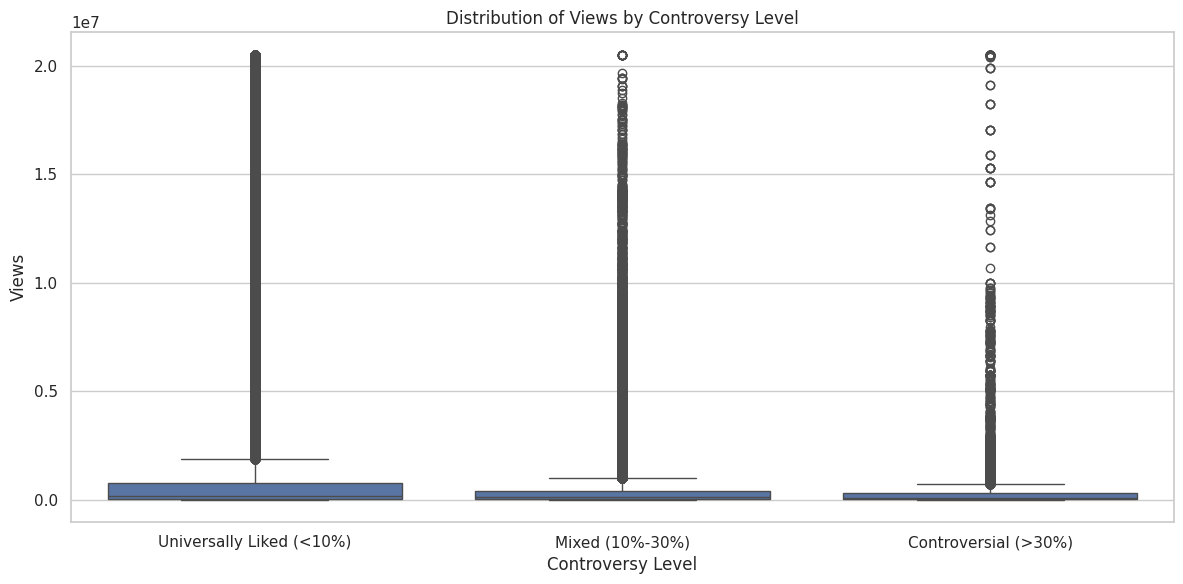

In [ ]:

# Handle zero division and filter where likes + dislikes > 0
merged_df = merged_df.copy()
engaged_df = merged_df[(merged_df['likes'] + merged_df['dislikes']) > 0]

# Calculate dislike ratio
engaged_df['dislike_ratio'] = engaged_df['dislikes'] / (engaged_df['likes'] + engaged_df['dislikes'])

# Create controversy category
def label_controversy(ratio):
    if ratio < 0.1:
        return 'Universally Liked (<10%)'
    elif ratio < 0.3:
        return 'Mixed (10%-30%)'
    else:
        return 'Controversial (>30%)'

engaged_df['controversy_level'] = engaged_df['dislike_ratio'].apply(label_controversy)

# Group and compare average engagement
controversy_stats = engaged_df.groupby('controversy_level').agg({
    'video_id': 'count',
    'views': 'mean',
    'likes': 'mean',
    'dislikes': 'mean',
    'comment_count': 'mean'
}).sort_values('views', ascending=False)

print("\n--- Engagement Stats by Controversy Level ---")
print(controversy_stats)

# Plot average engagement
plt.figure(figsize=(14, 6))
controversy_stats[['views', 'likes', 'dislikes', 'comment_count']].plot(kind='bar')
plt.title('Average Engagement by Controversy Level')
plt.xlabel('Controversy Level')
plt.ylabel('Average Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Scatter plot: Views vs. Dislike Ratio
plt.figure(figsize=(14, 6))
sns.scatterplot(data=engaged_df, x='dislike_ratio', y='views', alpha=0.5)
plt.title('Views vs. Dislike Ratio')
plt.xlabel('Dislike Ratio')
plt.ylabel('Views')
plt.tight_layout()
plt.show()

# Boxplot for deeper comparison
plt.figure(figsize=(12, 6))
sns.boxplot(data=engaged_df, x='controversy_level', y='views')
plt.title('Distribution of Views by Controversy Level')
plt.ylabel('Views')
plt.xlabel('Controversy Level')
plt.tight_layout()
plt.show()


### 5. How do video tags influence engagement, and which tags are most commonly used in trending videos?

<ipython-input-34-c37679fe39a8>:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




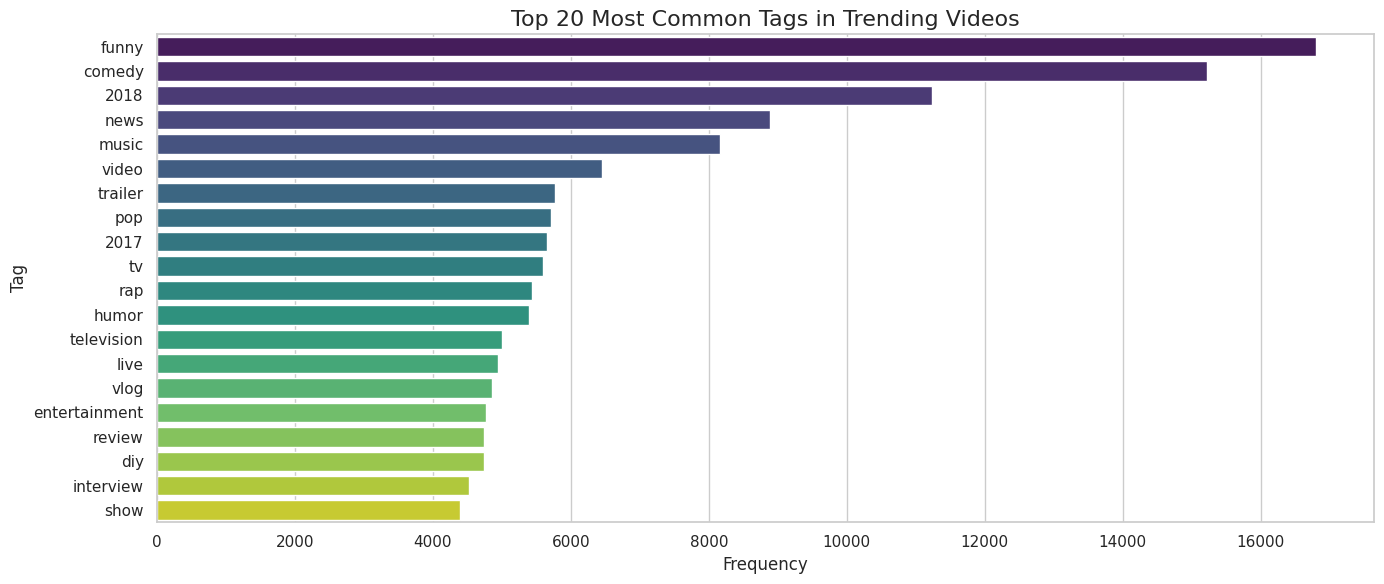

<ipython-input-34-c37679fe39a8>:40: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-34-c37679fe39a8>:43: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-34-c37679fe39a8>:46: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-34-c37679fe39a8>:49: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-34-c37679fe39a8>:56: UserWarning:

Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu 

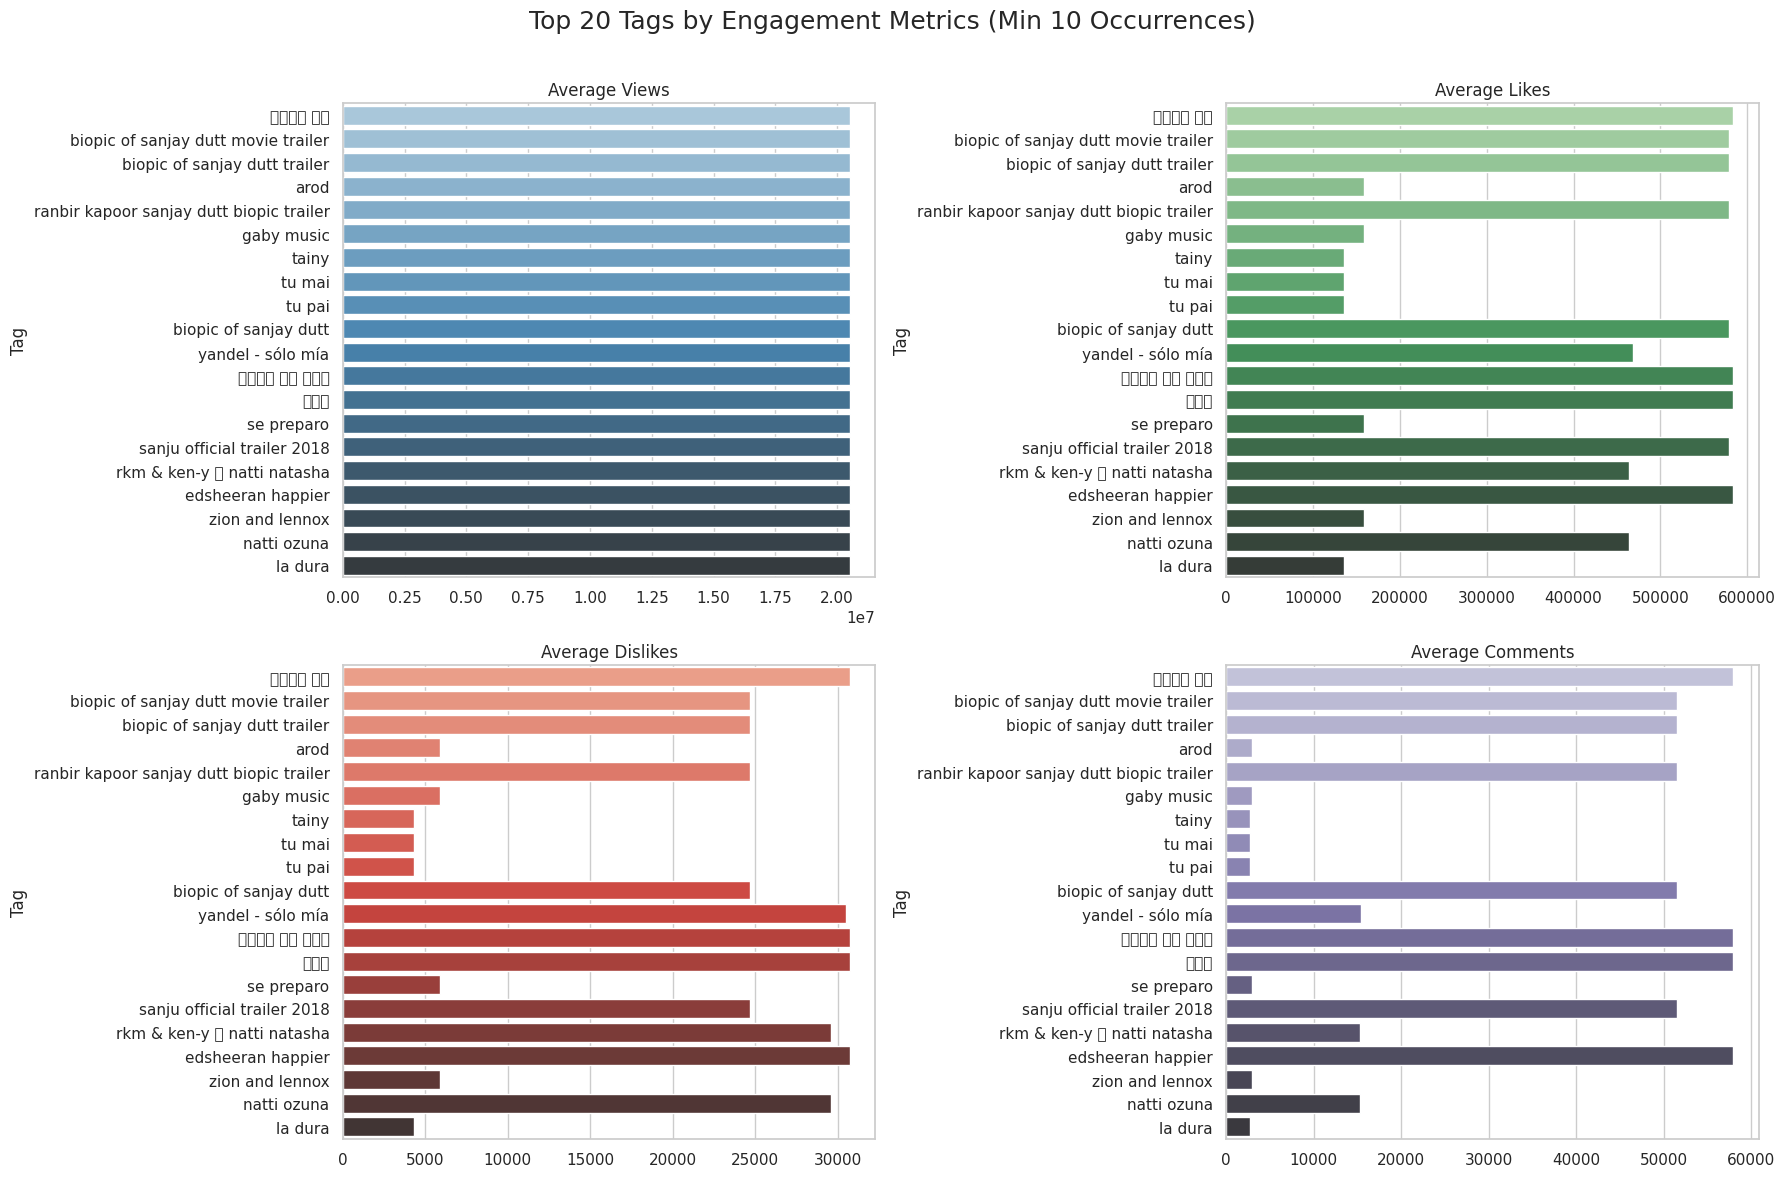

In [ ]:
# Prepare and clean tags
tag_df = merged_df[['video_id', 'tags', 'views', 'likes', 'dislikes', 'comment_count']].copy()

# Normalize tag strings
tag_df['tags'] = tag_df['tags'].fillna('').str.lower().str.replace('"', '').str.replace('[none]', '', regex=False)

# Split and explode tags
tag_df['tag_list'] = tag_df['tags'].str.split('|')
tag_df_exploded = tag_df.explode('tag_list')
tag_df_exploded['tag_list'] = tag_df_exploded['tag_list'].str.strip()
tag_df_exploded = tag_df_exploded[tag_df_exploded['tag_list'] != '']

# Tag frequency
tag_counts = tag_df_exploded['tag_list'].value_counts().head(20)

plt.figure(figsize=(14, 6))
sns.barplot(x=tag_counts.values, y=tag_counts.index, palette='viridis')
plt.title('Top 20 Most Common Tags in Trending Videos', fontsize=16)
plt.xlabel('Frequency')
plt.ylabel('Tag')
plt.tight_layout()
plt.show()

# Average engagement per tag (filter tags that appear more than 10 times)
tag_engagement = tag_df_exploded.groupby('tag_list').agg({
    'video_id': 'count',
    'views': 'mean',
    'likes': 'mean',
    'dislikes': 'mean',
    'comment_count': 'mean'
}).rename(columns={'video_id': 'tag_count'})

tag_engagement_filtered = tag_engagement[tag_engagement['tag_count'] > 10]
tag_engagement_sorted = tag_engagement_filtered.sort_values('views', ascending=False).head(20)

# Plot average engagement
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Top 20 Tags by Engagement Metrics (Min 10 Occurrences)', fontsize=18)

sns.barplot(data=tag_engagement_sorted, x='views', y=tag_engagement_sorted.index, ax=axes[0, 0], palette='Blues_d')
axes[0, 0].set_title('Average Views')

sns.barplot(data=tag_engagement_sorted, x='likes', y=tag_engagement_sorted.index, ax=axes[0, 1], palette='Greens_d')
axes[0, 1].set_title('Average Likes')

sns.barplot(data=tag_engagement_sorted, x='dislikes', y=tag_engagement_sorted.index, ax=axes[1, 0], palette='Reds_d')
axes[1, 0].set_title('Average Dislikes')

sns.barplot(data=tag_engagement_sorted, x='comment_count', y=tag_engagement_sorted.index, ax=axes[1, 1], palette='Purples_d')
axes[1, 1].set_title('Average Comments')

for ax in axes.flat:
    ax.set_ylabel('Tag')
    ax.set_xlabel('')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


### 6. How does the length of a video title impact engagement levels?

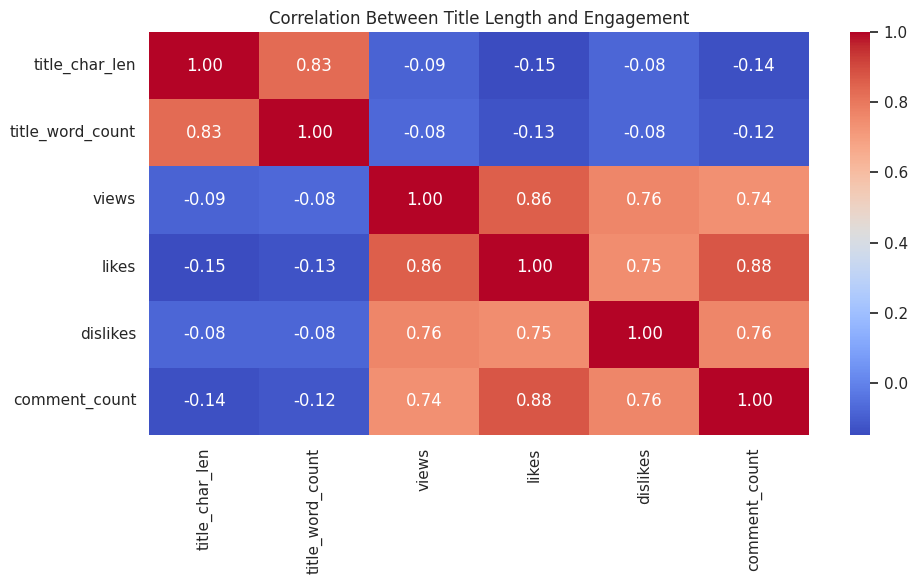

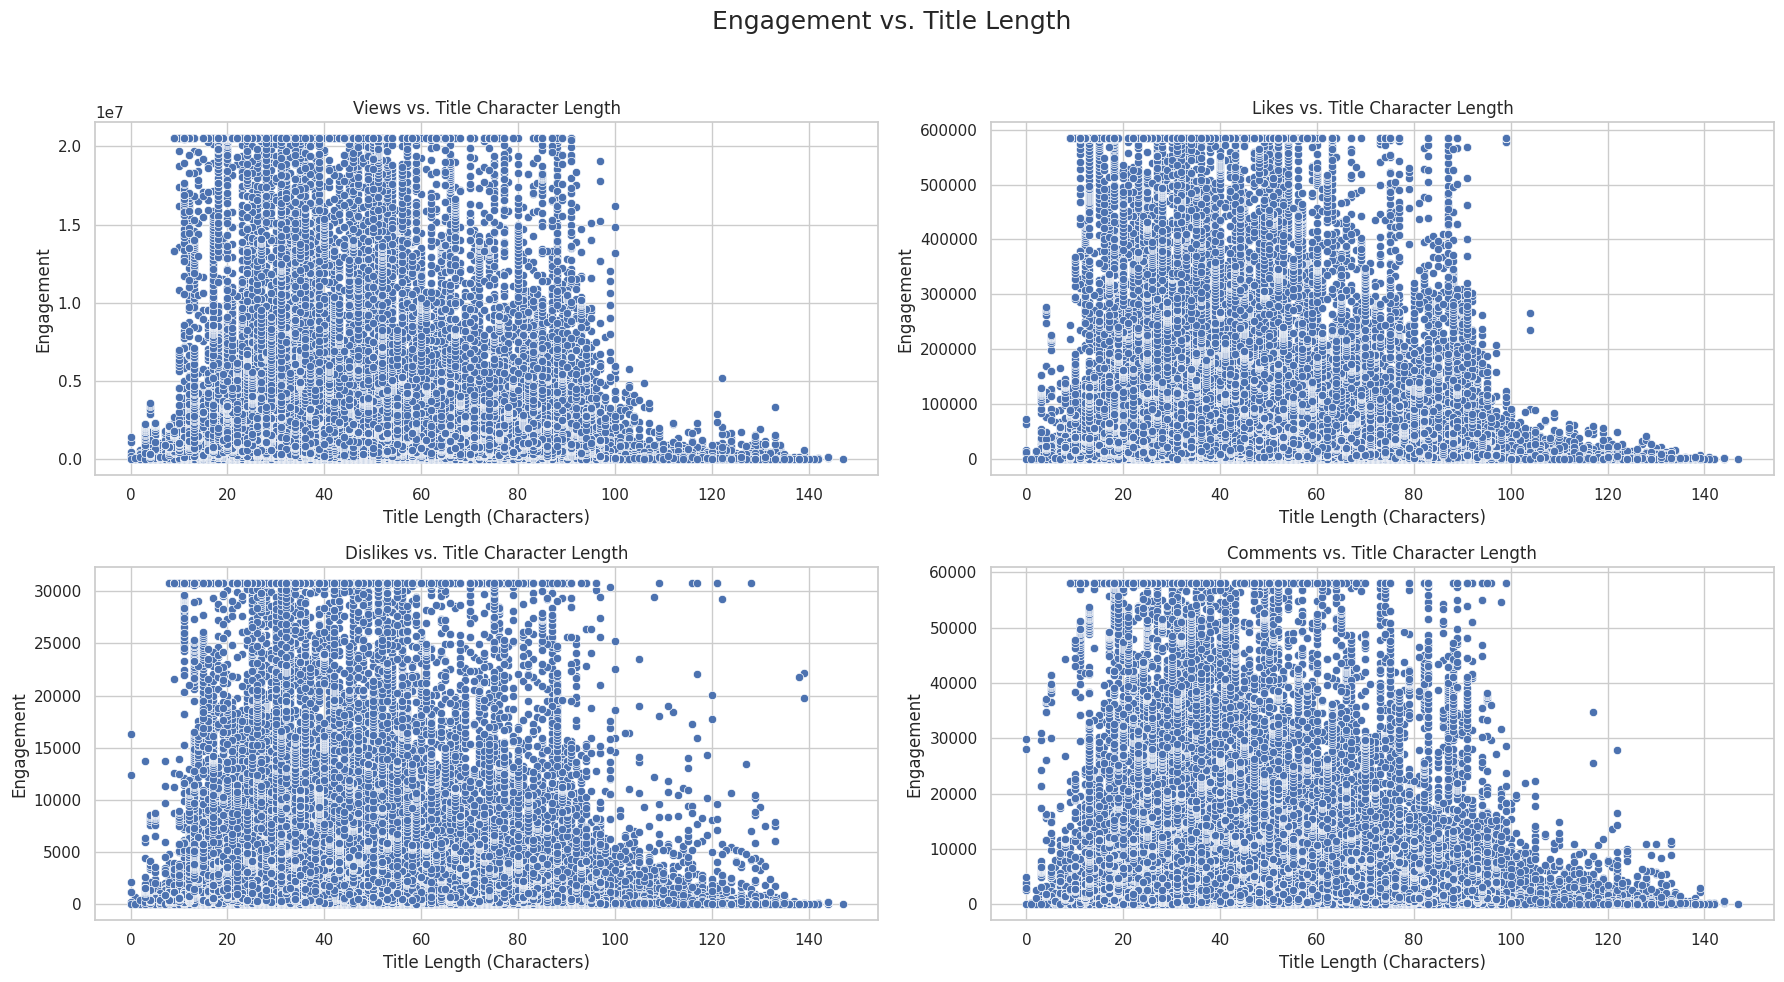

<ipython-input-37-2967d51e2c69>:41: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



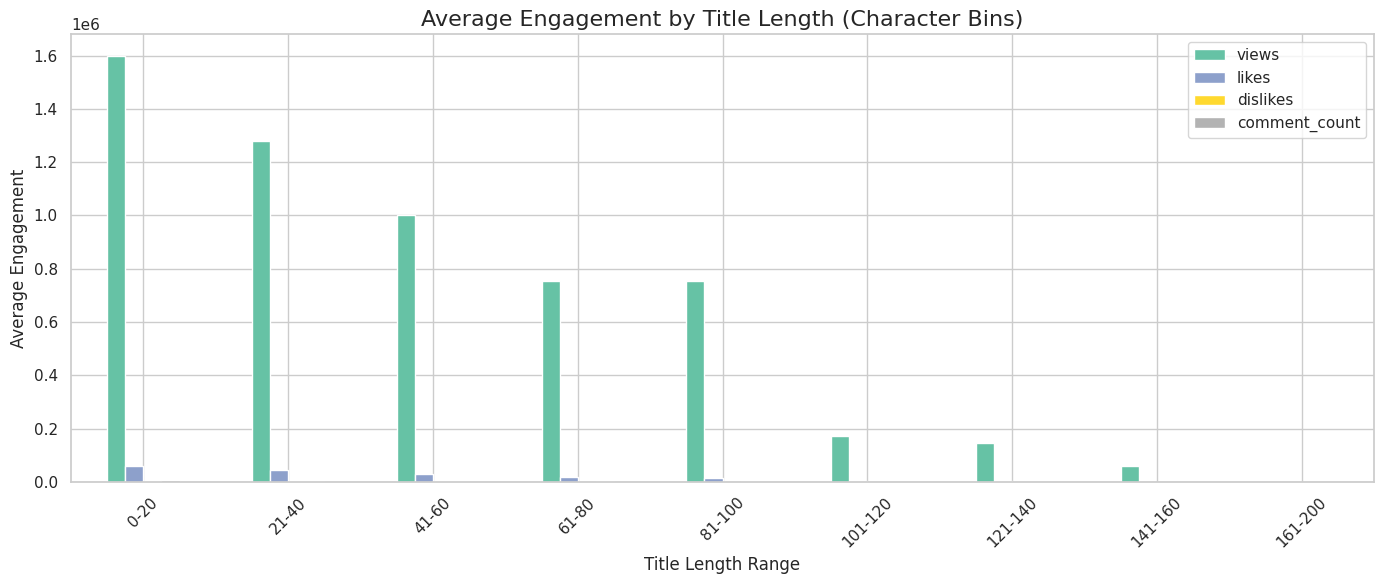

In [ ]:
# Create title length features
merged_df['title_char_len'] = merged_df['title'].astype(str).str.len()
merged_df['title_word_count'] = merged_df['title'].astype(str).str.split().apply(len)

# Correlation matrix
corr_metrics = merged_df[['title_char_len', 'title_word_count', 'views', 'likes', 'dislikes', 'comment_count']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_metrics, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Title Length and Engagement')
plt.tight_layout()
plt.show()

# Plot engagement vs title character length
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('Engagement vs. Title Length', fontsize=18)

sns.scatterplot(data=merged_df, x='title_char_len', y='views', ax=axes[0, 0])
axes[0, 0].set_title('Views vs. Title Character Length')

sns.scatterplot(data=merged_df, x='title_char_len', y='likes', ax=axes[0, 1])
axes[0, 1].set_title('Likes vs. Title Character Length')

sns.scatterplot(data=merged_df, x='title_char_len', y='dislikes', ax=axes[1, 0])
axes[1, 0].set_title('Dislikes vs. Title Character Length')

sns.scatterplot(data=merged_df, x='title_char_len', y='comment_count', ax=axes[1, 1])
axes[1, 1].set_title('Comments vs. Title Character Length')

for ax in axes.flat:
    ax.set_xlabel('Title Length (Characters)')
    ax.set_ylabel('Engagement')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#  Group by binned title lengths
merged_df['title_len_bin'] = pd.cut(merged_df['title_char_len'], bins=[0, 20, 40, 60, 80, 100, 120, 140, 160, 200],
                                    labels=['0-20', '21-40', '41-60', '61-80', '81-100', '101-120', '121-140', '141-160', '161-200'])

length_engagement = merged_df.groupby('title_len_bin')[['views', 'likes', 'dislikes', 'comment_count']].mean()

#  Visualize binned engagement
length_engagement.plot(kind='bar', figsize=(14, 6), colormap='Set2')
plt.title('Average Engagement by Title Length (Character Bins)', fontsize=16)
plt.xlabel('Title Length Range')
plt.ylabel('Average Engagement')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 7. Is there a relationship between video title sentiment, whether positive, neutral, or negative, and engagement levels? (extra point)

Sentiment Distribution:
title_sentiment
Neutral     293272
Positive     49870
Negative     20201
Name: count, dtype: int64

Average Engagement by Title Sentiment:
                        views         likes     dislikes  comment_count
title_sentiment                                                        
Negative         1.910983e+06  53394.851452  2418.411480    5862.631560
Positive         1.388353e+06  39370.267718  1603.069186    3783.235617
Neutral          9.014566e+05  28272.537985  1305.912215    2962.481737


<Figure size 1400x600 with 0 Axes>

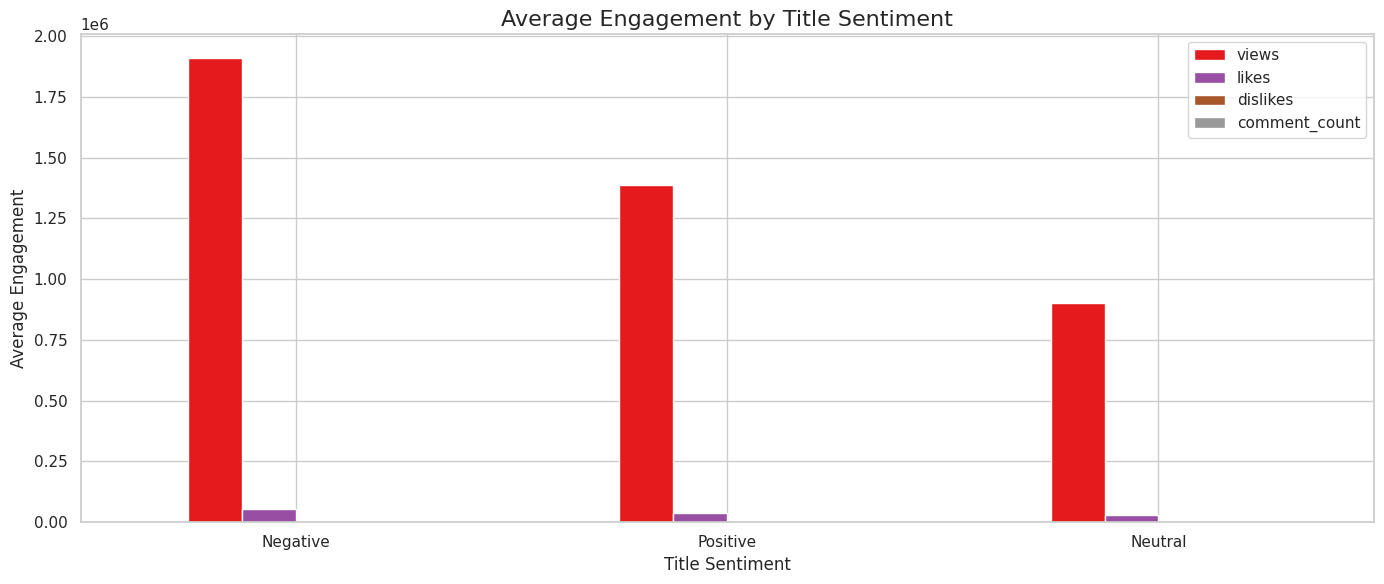

In [ ]:
from textblob import TextBlob

# Compute sentiment polarity of titles
def get_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0
    return TextBlob(text).sentiment.polarity

merged_df['title_sentiment_score'] = merged_df['title'].apply(get_sentiment)

# Categorize sentiment
def label_sentiment(score):
    if score > 0.1:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

merged_df['title_sentiment'] = merged_df['title_sentiment_score'].apply(label_sentiment)

# View sentiment distribution
print("Sentiment Distribution:")
print(merged_df['title_sentiment'].value_counts())

# Average engagement by sentiment
sentiment_engagement = merged_df.groupby('title_sentiment')[['views', 'likes', 'dislikes', 'comment_count']].mean().sort_values('views', ascending=False)

print("\nAverage Engagement by Title Sentiment:")
print(sentiment_engagement)

# Visualize
plt.figure(figsize=(14, 6))
sentiment_engagement.plot(kind='bar', colormap='Set1', figsize=(14, 6))
plt.title('Average Engagement by Title Sentiment', fontsize=16)
plt.xlabel('Title Sentiment')
plt.ylabel('Average Engagement')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### 8. Do clickbait-style titles, such as those containing words like ”shocking” or ”must watch,” result in higher engagement? (extra point)


Average Engagement by Clickbait Titles:
                     views         likes     dislikes  comment_count
is_clickbait                                                        
False         1.027212e+06  31281.379438  1413.051281    3241.414152
True          6.771690e+05  20165.810251   850.279766    2611.263455


<Figure size 1400x600 with 0 Axes>

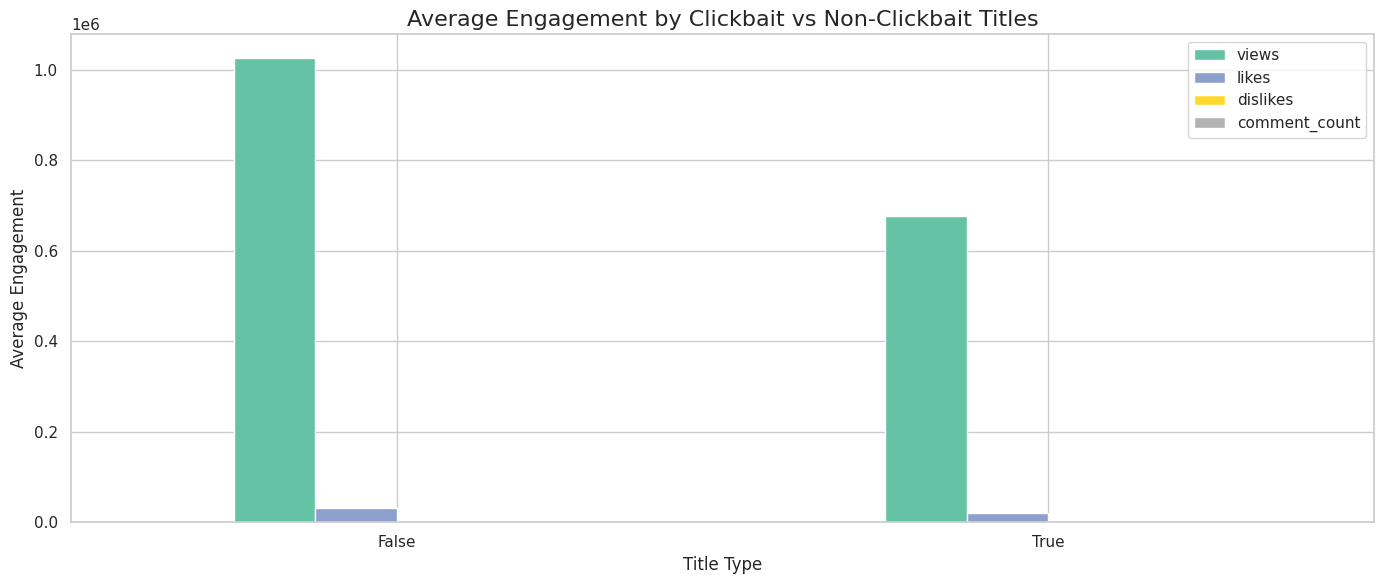

In [ ]:

#  Define clickbait keywords
clickbait_keywords = ['shocking', 'must watch', 'you won’t believe', 'unbelievable', 'revealed', 'surprising', 'secret', 'exposed', 'crazy', 'amazing']

#  Function to classify clickbait titles
def is_clickbait(title):
    if isinstance(title, str):
        title = title.lower()
        for keyword in clickbait_keywords:
            if keyword in title:
                return True
    return False

#  Apply clickbait classification
merged_df['is_clickbait'] = merged_df['title'].apply(is_clickbait)

#  Average engagement by clickbait vs non-clickbait
clickbait_engagement = merged_df.groupby('is_clickbait')[['views', 'likes', 'dislikes', 'comment_count']].mean()

print("\nAverage Engagement by Clickbait Titles:")
print(clickbait_engagement)

#  Visualize clickbait vs non-clickbait engagement
plt.figure(figsize=(14, 6))
clickbait_engagement.plot(kind='bar', colormap='Set2', figsize=(14, 6))
plt.title('Average Engagement by Clickbait vs Non-Clickbait Titles', fontsize=16)
plt.xlabel('Title Type')
plt.ylabel('Average Engagement')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Statistical Questions

### 1.Is there a significant association between the day of the week a video is published and its likelihood of trending?

H₀ (Null Hypothesis): There is no association between the day of the week a video is published and its likelihood of trending. (They are independent.)

H₁ (Alternative Hypothesis): There is an association between the day of the week a video is published and its likelihood of trending. (They are dependent.)

Chi-Square Test Results:
Chi2 Statistic: 0.0675
Degrees of Freedom: 6
P-value: 1.0000
Fail to reject H₀: No significant association between publish day and likelihood of trending.


<ipython-input-41-700af8dee0fc>:44: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




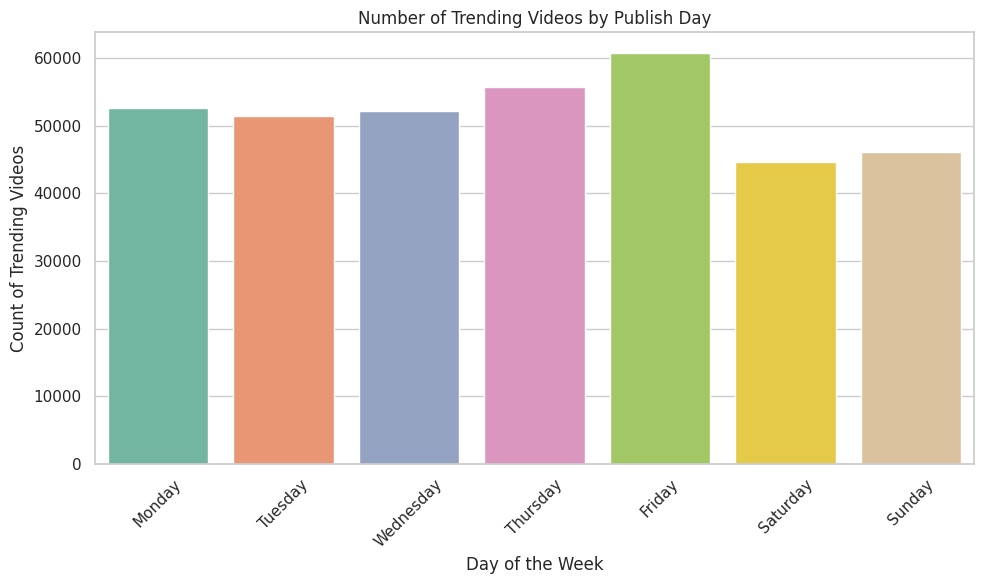

In [ ]:
# Ensure datetime and extract weekday
merged_df['publish_time'] = pd.to_datetime(merged_df['publish_time'])
merged_df['publish_day_of_week'] = merged_df['publish_time'].dt.day_name()

# Define day order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Count trending videos by day
trending_counts = merged_df['publish_day_of_week'].value_counts().reindex(day_order).fillna(0)

# Simulate a larger number of total uploads (500 uploads per day)
simulated_uploads = pd.Series(500, index=day_order)

# Compute non-trending counts
non_trending_counts = simulated_uploads - trending_counts
non_trending_counts = non_trending_counts.clip(lower=1)  # Ensure no zero cells

# Ensure trending counts are also non-zero for all days (if needed)
trending_counts = trending_counts.replace(0, 1)

# Build the contingency table
contingency_table = np.array([
    trending_counts.values,
    non_trending_counts.values
])

# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print results
print("Chi-Square Test Results:")
print(f"Chi2 Statistic: {chi2:.4f}")
print(f"Degrees of Freedom: {dof}")
print(f"P-value: {p:.4f}")

alpha = 0.05
if p < alpha:
    print(" Reject H₀: There IS a significant association between publish day and likelihood of trending.")
else:
    print("Fail to reject H₀: No significant association between publish day and likelihood of trending.")

# Optional: Visualize
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_df, x='publish_day_of_week', order=day_order, palette='Set2')
plt.title("Number of Trending Videos by Publish Day")
plt.xlabel("Day of the Week")
plt.ylabel("Count of Trending Videos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Although the Chi-Square test does not find a statistically significant association, visual analysis reveals that Fridays see a noticeably higher number of trending videos, suggesting a potential trend worth exploring further.

### 2. Is there a significant difference in viewer engagement (likes-to-views ratio) across different video categories?

H₀ (null hypothesis):
The distribution of engagement (likes-to-views ratio) is the same across all categories.

H₁ (alternative hypothesis):
At least one category has a different distribution of engagement than the others.

Kruskal-Wallis H-test for Likes-to-Views Ratio by Category:
H statistic = 45434.7984
p-value = 0.0000
 Significant difference in engagement between categories.


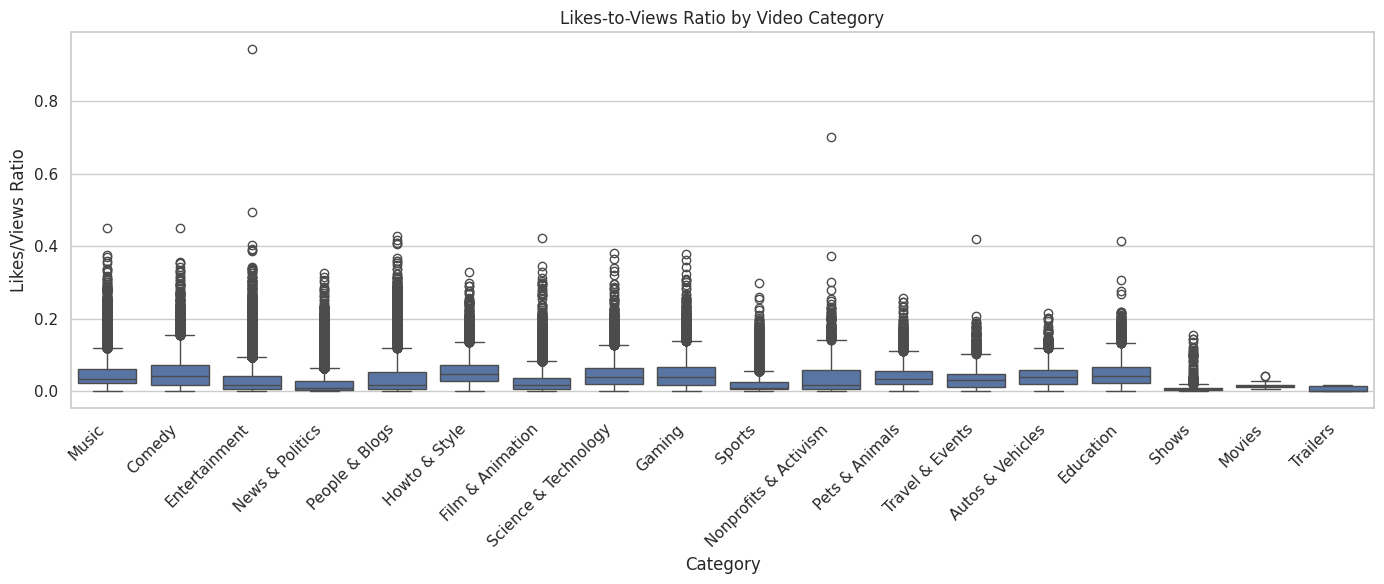

In [ ]:
# Compute likes-to-views ratio
merged_df['likes_views_ratio'] = merged_df['likes'] / merged_df['views']

# Drop rows with NaNs or infinite values
merged_df = merged_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['likes_views_ratio', 'category_id'])

# Map category IDs to names in a new column
merged_df['category_name'] = merged_df['category_id'].map(lambda cid: category_map.get(cid, f"ID {cid}"))

# Group data by category name instead of ID
grouped = merged_df.groupby('category_name')['likes_views_ratio'].apply(list)

# Perform Kruskal-Wallis H-test
h_stat, p_val = kruskal(*grouped)

# Print result
print("Kruskal-Wallis H-test for Likes-to-Views Ratio by Category:")
print(f"H statistic = {h_stat:.4f}")
print(f"p-value = {p_val:.4f}")

if p_val < 0.05:
    print(" Significant difference in engagement between categories.")
else:
    print(" No significant difference in engagement between categories.")

#  Visualize with category names
plt.figure(figsize=(14, 6))
sns.boxplot(x='category_name', y='likes_views_ratio', data=merged_df)
plt.title('Likes-to-Views Ratio by Video Category')
plt.xlabel('Category')
plt.ylabel('Likes/Views Ratio')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
